In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from neuralop.models.fno import TFNO
from neuralop.models.fno import TFNO3d
from neuralop.training.trainer import Trainer
from neuralop.utils import count_model_params
from neuralop.losses.data_losses import LpLoss, H1Loss
import pdb
import torch.nn as nn
import sys
from astropy.io import fits
from torch.utils.data.dataset import Subset
import random
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset
from torchvision.transforms.functional import normalize
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from tqdm import tqdm
from torch.utils.data import random_split
import h5py
import torch.nn as nn
import time

device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device0)
#print(device1)

from functools import partialmethod
import torch
import torch.nn as nn
import torch.nn.functional as F
from neuralop.layers.spectral_convolution import SpectralConv
from neuralop.layers.padding import DomainPadding
from neuralop.layers.fno_block import FNOBlocks
from neuralop.layers.mlp import MLP
from neuralop.models.base_model import BaseModel

cuda:0


In [2]:
import torch
from torch.utils.data import Dataset
import numpy as np
import h5py
import pandas as pd

class CustomDataset(Dataset):
    def __init__(
        self, 
        hdf5_file_paths, 
        x_lengths, 
        y_lengths, 
        z_lengths, 
        excel_path
    ):
        """
        Args:
            hdf5_file_paths (list): List of paths to the HDF5 files [Bx_file, By_file, Bz_file].
            x_lengths, y_lengths, z_lengths (np.ndarray): Arrays of lengths (1D).
            excel_path (str): Path to the Excel file containing NOAA AR, date, and type.
        """
        # 1) Store HDF5 file paths and open the files
        self.hdf5_file_paths = hdf5_file_paths
        self.hdf5_files = [h5py.File(path, 'r') for path in self.hdf5_file_paths]
        
        # 2) Store lengths
        self.x_lengths = x_lengths
        self.y_lengths = y_lengths
        self.z_lengths = z_lengths
        
        # 3) Read Excel file to get the NOAA AR, date, and type
        df = pd.read_excel(excel_path)
        
        # Make sure the rows in 'df' match the exact order of samples in HDF5
        # If you need to sort the DataFrame, do it here, e.g.:
        # df = df.sort_values(by='date')  # or by 'NOAA AR', etc.
        # df = df.reset_index(drop=True)

        # Just store the raw type strings:
        self.type_labels_str = df['type'].astype(str).values
        
        # 4) Assume all HDF5 files have the same number of samples
        self.dataset_length = len(self.hdf5_files[0])
        
        # 5) Calculate means and stds for normalization
        self.x_mean = np.mean(self.x_lengths)
        self.x_std = np.std(self.x_lengths)

        self.y_mean = np.mean(self.y_lengths)
        self.y_std = np.std(self.y_lengths)

        self.z_mean = np.mean(self.z_lengths)
        self.z_std = np.std(self.z_lengths)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        # ---------------------
        # 1) Read input arrays
        # ---------------------
        input_data_x = torch.from_numpy(
            self.hdf5_files[0][f'sample_{idx}/input'][:]
        ).float()
        input_data_y = torch.from_numpy(
            self.hdf5_files[1][f'sample_{idx}/input'][:]
        ).float()
        input_data_z = torch.from_numpy(
            self.hdf5_files[2][f'sample_{idx}/input'][:]
        ).float()

        # ----------------------
        # 2) Read output arrays
        # ----------------------
        output_data_x = torch.from_numpy(
            self.hdf5_files[0][f'sample_{idx}/output'][:]
        ).float()
        output_data_y = torch.from_numpy(
            self.hdf5_files[1][f'sample_{idx}/output'][:]
        ).float()
        output_data_z = torch.from_numpy(
            self.hdf5_files[2][f'sample_{idx}/output'][:]
        ).float()

        # ------------------------------------
        # 3) Select some subset of output data
        # ------------------------------------
        selected_output_data_x = output_data_x[:25]
        selected_output_data_y = output_data_y[:25]
        selected_output_data_z = output_data_z[:25]

        # ------------------------------------
        # 4) Stack inputs into multi-channel
        # ------------------------------------
        input_data = torch.stack(
            (input_data_x, input_data_y, input_data_z), dim=0
        ).unsqueeze(0)

        # ------------------------------------
        # 5) Stack selected outputs
        # ------------------------------------
        output_data = torch.stack(
            (selected_output_data_x, selected_output_data_y, selected_output_data_z), 
            dim=1
        )

        # ------------------------------------
        # 6) Normalize lengths
        # ------------------------------------
        x_length_normalized = (self.x_lengths[idx] - self.x_mean) / self.x_std
        y_length_normalized = (self.y_lengths[idx] - self.y_mean) / self.y_std
        z_length_normalized = (self.z_lengths[idx] - self.z_mean) / self.z_std
        
        length_tensor = torch.tensor(
            [x_length_normalized, y_length_normalized, z_length_normalized],
            dtype=torch.float32
        ).unsqueeze(0)

        # ------------------------------------
        # 7) Get the string label from Excel
        # ------------------------------------
        type_label_str = self.type_labels_str[idx]
        # This remains a Python string. If you only need to read it
        # later for grouping or analysis, you can just store it in the sample dict. 
        # (If you need it as a tensor, you can store it as an object 
        #  but note that PyTorch won't do much with it for training.)

        sample = {
            'input': input_data,      # shape: (1, 3, H, W) or similar
            'output': output_data,    # shape: (N, 3) depending on your slicing
            'lengths': length_tensor, # shape: (1, 3)
            'type_label_str': type_label_str,  # e.g. 'β' or 'βγ'
        }
        return sample


from torch.utils.data import DataLoader, Subset

# HDF5 file paths
input1 = "NLFFF_data/NLFFF_Bx_rmns_100.h5"
input2 = "NLFFF_data/NLFFF_By_rmns_100.h5"
input3 = "NLFFF_data/NLFFF_Bz_rmns_10.h5"

# NumPy length arrays
x_lengths = np.load("NLFFF_data/x_height.npy")
y_lengths = np.load("NLFFF_data/y_height.npy")
z_lengths = np.load("NLFFF_data/z_height.npy")

# Excel path
excel_path = "NLFFF_data/NLFFF_datatype.xlsx"

# Initialize dataset
dataset = CustomDataset(
    [input1, input2, input3],
    x_lengths,
    y_lengths,
    z_lengths,
    excel_path
)

train_size = 143
test_size = 27

train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, train_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=8, persistent_workers=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=8, persistent_workers=False)

for batch in train_loader:
    inputs = batch['input']
    outputs = batch['output']
    lengths = batch['lengths']
    type_strings = batch['type_label_str']

print(inputs.shape)


torch.Size([3, 1, 3, 257, 513])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PhysicsInformedLoss(nn.Module):
    def __init__(self, weight=0.35, alpha=1.0, beta=1.0, gamma=1.0):
        super(PhysicsInformedLoss, self).__init__()
        self.weight = weight
        self.alpha = alpha  
        self.beta = beta    
        self.gamma = gamma  

    def forward(self, output, target): 
        divergence_loss = self.compute_divergence_loss(output)

        force_free_loss = self.compute_force_free_loss(output)

        total_loss = self.weight * ((self.beta * divergence_loss) + \
                     (self.gamma * force_free_loss))
        return total_loss

    def compute_divergence_loss(self, output):
        batch_size, depth, components, height, width = output.shape
        B = output.permute(0, 2, 1, 3, 4)  # B: [batch_size, 3, depth, height, width]
        channels = components

        device = output.device

        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)
        kernel_dx = kernel_dx.repeat(channels, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(channels, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(channels, 1, 1, 1, 1)

        dB_dx = F.conv3d(B, kernel_dx, padding=(0, 0, 1), groups=channels)
        dB_dy = F.conv3d(B, kernel_dy, padding=(0, 1, 0), groups=channels)
        dB_dz = F.conv3d(B, kernel_dz, padding=(1, 0, 0), groups=channels)

        # dB_x/dx
        dB_x_dx = dB_dx[:, 0, :, :, :]
        # dB_y/dy
        dB_y_dy = dB_dy[:, 1, :, :, :]
        # dB_z/dz
        dB_z_dz = dB_dz[:, 2, :, :, :]


        divergence = dB_x_dx + dB_y_dy + dB_z_dz
        divergence_loss = torch.mean(divergence ** 2)

        return divergence_loss

    def compute_force_free_loss(self, output):
        batch_size, depth, components, height, width = output.shape
        B = output.permute(0, 2, 1, 3, 4)  # B: [batch_size, 3, depth, height, width]
        channels = components  

        device = output.device

        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)

        kernel_dx = kernel_dx.repeat(channels, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(channels, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(channels, 1, 1, 1, 1)

        dB_dx = F.conv3d(B, kernel_dx, padding=(0, 0, 1), groups=channels)
        dB_dy = F.conv3d(B, kernel_dy, padding=(0, 1, 0), groups=channels)
        dB_dz = F.conv3d(B, kernel_dz, padding=(1, 0, 0), groups=channels)

        dB_x_dy = dB_dy[:, 0, :, :, :]
        dB_x_dz = dB_dz[:, 0, :, :, :]

        dB_y_dx = dB_dx[:, 1, :, :, :]
        dB_y_dz = dB_dz[:, 1, :, :, :]

        dB_z_dx = dB_dx[:, 2, :, :, :]
        dB_z_dy = dB_dy[:, 2, :, :, :]

        rot_x = dB_z_dy - dB_y_dz
        rot_y = dB_x_dz - dB_z_dx
        rot_z = dB_y_dx - dB_x_dy

        j = torch.stack([rot_x, rot_y, rot_z], dim=1)
        jxb = torch.cross(j, B, dim=1)
        B_magnitude_squared = torch.sum(B ** 2, dim=1, keepdim=True) + 1e-7
        force_free_loss = torch.mean(torch.sum(jxb ** 2, dim=1) / B_magnitude_squared.squeeze(1))

        return force_free_loss


class ECA3DLayer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECA3DLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [batch_size, channels, seq_len, height, width]
        
        # Global average pooling across seq_len, height, width
        y = self.avg_pool(x)  # Shape: [batch_size, channels, 1, 1, 1]

        # Apply 1D convolution across the channel dimension
        y = self.conv(y.squeeze(-1).squeeze(-1).transpose(-1, -2))  # Shape: [batch_size, 1, channels]
        y = y.transpose(-1, -2).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, channels, 1, 1, 1]

        # Apply attention to input
        return x * self.sigmoid(y).expand_as(x)

class DilatedConvYWithECA(nn.Module):
    def __init__(self, channels, dilation_y=2, k_size=3):
        super(DilatedConvYWithECA, self).__init__()
        self.conv = nn.Conv3d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=(1, 3, 1),  
            padding=(0, dilation_y, 0),  
            dilation=(1, dilation_y, 1),
            bias=False
        )
        self.activation = nn.ReLU()

        # ECA Attention layer
        self.eca = ECA3DLayer(channel=channels, k_size=k_size)

    def forward(self, x):
        # Apply dilated convolution
        x = self.conv(x)
        x = self.activation(x)

        # Apply ECA attention
        x = self.eca(x)
        
        return x

# CustomFNO Model with ECA-Net applied to lengths_lifted
class CustomFNO(BaseModel, name='CustomFNO'):
    def __init__(self, n_modes, hidden_channels, in_channels=3, out_channels=1,
                 lifting_channels=256, projection_channels=256, n_layers=4,
                 output_scaling_factor=None, max_n_modes=None,
                 fno_block_precision="full", use_mlp=False, mlp_dropout=0,
                 mlp_expansion=0.5, non_linearity=F.gelu, stabilizer=None,
                 norm=None, preactivation=False, fno_skip="linear",
                 mlp_skip="soft-gating", separable=False, factorization=None,
                 rank=1.0, joint_factorization=False, fixed_rank_modes=False,
                 implementation="factorized", decomposition_kwargs=dict(),
                 domain_padding=None, domain_padding_mode="one-sided",
                 fft_norm="forward", SpectralConv=SpectralConv,
                 **kwargs):
        
        super().__init__()
        self.n_dim = len(n_modes)
        self.n_layers = n_layers

        # Define the lifting layers for two inputs
        self.lifting1 = MLP(
            in_channels=in_channels,
            out_channels=hidden_channels,
            hidden_channels=lifting_channels,
            n_layers=2,
            n_dim=self.n_dim,
        )
        
        self.lifting_y = MLP(
            in_channels=3,  
            out_channels=hidden_channels,
            hidden_channels=lifting_channels,
            n_layers=2,
            n_dim=1,
        )

        # Define the ECA-Net block for lengths_lifted
        self.DilatedConvYWithECA = DilatedConvYWithECA(hidden_channels, dilation_y=2)

        # Define the FNO blocks
        self.fno_blocks = FNOBlocks(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            n_modes=n_modes,
            output_scaling_factor=output_scaling_factor,
            use_mlp=use_mlp,
            mlp_dropout=mlp_dropout,
            mlp_expansion=mlp_expansion,
            non_linearity=non_linearity,
            stabilizer=stabilizer,
            norm=norm,
            preactivation=preactivation,
            fno_skip=fno_skip,
            mlp_skip=mlp_skip,
            max_n_modes=max_n_modes,
            fno_block_precision=fno_block_precision,
            rank=rank,
            fft_norm=fft_norm,
            fixed_rank_modes=fixed_rank_modes,
            implementation=implementation,
            separable=separable,
            factorization=factorization,
            decomposition_kwargs=decomposition_kwargs,
            joint_factorization=joint_factorization,
            SpectralConv=SpectralConv,
            n_layers=n_layers,
            **kwargs
        )

        # Define the projection layer
        self.projection = MLP(
            in_channels=hidden_channels,
            out_channels=out_channels,
            hidden_channels=projection_channels,
            n_layers=2,
            n_dim=self.n_dim,
            non_linearity=non_linearity,
        )

    def forward(self, x1, lengths):
        """Forward pass for the Custom FNO model.

        Parameters
        ----------
        x1 : tensor
            Input tensor of shape [batch_size, 1, 3, 257, 513]
        lengths : tensor
            Tensor containing the normalized lengths of shape [batch_size, 1, 3]
        """
        x_orig = x1.clone()
        
        # Apply lifting to the input
        x1 = self.lifting1(x1)  # Result shape: [batch_size, hidden_channels, 3, 257, 513]

        # Reshape lengths for processing
        lengths = lengths.view(-1, 3, 1)  # Shape [batch_size, 3, 1] for processing

        # Process lengths through lifting
        lengths_lifted = self.lifting_y(lengths)  # Result shape: [batch_size, hidden_channels, 3]
        
        # Reshape lengths_lifted to match the spatial dimensions of x1
        lengths_lifted = lengths_lifted.unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, hidden_channels, 3, 1, 1]

        # Apply ECA-Net block to lengths_lifted before adding to x1
        lengths_lifted = self.DilatedConvYWithECA(lengths_lifted)

        # Apply lengths_lifted to x1 (add)
        x1 = x1 + lengths_lifted

        # Apply FNO blocks
        for layer_idx in range(self.n_layers):
            x1 = self.fno_blocks(x1, layer_idx)

        # Apply projection layer
        x1 = self.projection(x1)

        x1[:, 0, :, :, :] = x_orig[:, 0, :, :, :]

        return x1

In [4]:
model = CustomFNO(n_modes = (32, 32, 32), in_channels=1, out_channels=25, n_layers = 6,
               hidden_channels=32, use_mlp=True, factorization='tucker', rank=0.2)
model = model.to(device0)

n_params = count_model_params(model)
print(f'\nYour model has {n_params} parameters.')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=1, verbose=True)

h1loss = H1Loss(d=2)
print(model)


Your model has 40383772 parameters.
CustomFNO(
  (lifting1): MLP(
    (fcs): ModuleList(
      (0): Conv3d(1, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(256, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (lifting_y): MLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (DilatedConvYWithECA): DilatedConvYWithECA(
    (conv): Conv3d(32, 32, kernel_size=(1, 3, 1), stride=(1, 1, 1), padding=(0, 2, 0), dilation=(1, 2, 1), bias=False)
    (activation): ReLU()
    (eca): ECA3DLayer(
      (avg_pool): AdaptiveAvgPool3d(output_size=1)
      (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-5): 6 x ComplexTuckerTensor(shape=(32, 32, 32, 32, 17), rank=(23, 23, 23, 23, 12))
      )
    )
    (fno_skips): Modul

/home/jc2687/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
def l2_loss(pred, target):
    return F.mse_loss(pred, target, reduction='mean')

In [11]:
import os
import time
import csv
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

num_epochs = 150
print_frequency = 40
save_checkpoint_start_epoch = 50
save_checkpoint_interval = 10
checkpoint_dir = "result/NLFFF_Cube2Step/step1"
results_file = os.path.join(checkpoint_dir, "result.csv")
physics_loss_fn = PhysicsInformedLoss(weight=0.35, alpha=1.0, beta=1, gamma=1)

# 准备CSV文件
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'comp', 'r2', 'relative_error', 'mse', 'mae', 'psnr', 'ssim'])

train_losses_Bx = []
train_losses_By = []
train_losses_Bz = []
test_losses_Bx = []
test_losses_By = []
test_losses_Bz = []
physics_losses = []
epoch_durations = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    epoch_loss_Bx = 0.0
    epoch_loss_By = 0.0
    epoch_loss_Bz = 0.0
    epoch_physics_loss = 0.0

    train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Train Epoch {epoch+1}/{num_epochs}')
    for batch_idx, sample in train_loader_tqdm:
        optimizer.zero_grad()
        data, target = sample['input'].to(device0), sample['output'].to(device0)
        lengths = sample['lengths'].to(device0)  

        output = model(data, lengths)

        loss_Bx = h1loss(output[:, :, 0, :, :], target[:, :, 0, :, :]).mean()
        loss_By = h1loss(output[:, :, 1, :, :], target[:, :, 1, :, :]).mean()
        loss_Bz = h1loss(output[:, :, 2, :, :], target[:, :, 2, :, :]).mean()

        physics_loss = physics_loss_fn(output, target)
            
        total_loss = loss_Bx + loss_By + loss_Bz + physics_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss_Bx += loss_Bx.item()
        epoch_loss_By += loss_By.item()
        epoch_loss_Bz += loss_Bz.item()
        epoch_physics_loss += physics_loss.item()

        if batch_idx % print_frequency == 0:
            train_loader_tqdm.set_postfix(
                loss_Bx=loss_Bx.item(),
                loss_By=loss_By.item(),
                loss_Bz=loss_Bz.item(),
                physics_loss=physics_loss.item()
            )

    avg_loss_Bx = epoch_loss_Bx / len(train_loader)
    avg_loss_By = epoch_loss_By / len(train_loader)
    avg_loss_Bz = epoch_loss_Bz / len(train_loader)
    avg_physics_loss = epoch_physics_loss / len(train_loader)

    train_losses_Bx.append(avg_loss_Bx)
    train_losses_By.append(avg_loss_By)
    train_losses_Bz.append(avg_loss_Bz)
    physics_losses.append(avg_physics_loss)

    model.eval()
    epoch_r2_Bx = []
    epoch_r2_By = []
    epoch_r2_Bz = []
    test_loader_tqdm = tqdm(test_loader, total=len(test_loader), desc=f'Test Epoch {epoch+1}/{num_epochs}')
    with torch.no_grad():
        for sample in test_loader_tqdm:
            x = sample['input'].to(device0)
            lengths = sample['lengths'].to(device0)  
            target = sample['output'].cpu().numpy()
            output = model(x, lengths).cpu().numpy()

            for true_sample, pred_sample in zip(target, output):
                r2_Bx = r2_score(true_sample[:, 0].flatten(), pred_sample[:, 0].flatten())
                r2_By = r2_score(true_sample[:, 1].flatten(), pred_sample[:, 1].flatten())
                r2_Bz = r2_score(true_sample[:, 2].flatten(), pred_sample[:, 2].flatten())

                epoch_r2_Bx.append(r2_Bx)
                epoch_r2_By.append(r2_By)
                epoch_r2_Bz.append(r2_Bz)

    avg_r2_Bx = np.mean(epoch_r2_Bx)
    avg_r2_By = np.mean(epoch_r2_By)
    avg_r2_Bz = np.mean(epoch_r2_Bz)

    test_losses_Bx.append(avg_r2_Bx)
    test_losses_By.append(avg_r2_By)
    test_losses_Bz.append(avg_r2_Bz)

    end_time = time.time()
    epoch_duration = end_time - start_time
    epoch_durations.append(epoch_duration)

    avg_train_loss_combined = (avg_loss_Bx + avg_loss_By + avg_loss_Bz + avg_physics_loss) / 3
    scheduler.step(avg_train_loss_combined)

    avg_epoch_duration = np.mean(epoch_durations)
    remaining_epochs = num_epochs - (epoch + 1)
    remaining_time = remaining_epochs * avg_epoch_duration
    hours, rem = divmod(remaining_time, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch: {epoch+1}/{num_epochs}, Duration: {epoch_duration:.2f}s, '
          f'Train Loss - Bx: {avg_loss_Bx:.4f}, By: {avg_loss_By:.4f}, Bz: {avg_loss_Bz:.4f}, Physics Loss: {avg_physics_loss:.4f}, '
          f'Test R2 - Bx: {avg_r2_Bx:.4f}, By: {avg_r2_By:.4f}, Bz: {avg_r2_Bz:.4f}')

    print(f'Estimated Remaining Time: {int(hours)}h {int(minutes)}m {int(seconds)}s')

    if (epoch + 1) >= save_checkpoint_start_epoch and (epoch + 1) % save_checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}: {checkpoint_path}")

        min_val = float('inf')
        max_val = float('-inf')
        for sample in test_loader:
            y_true_batch = sample['output'].numpy()
            batch_min = y_true_batch.min()
            batch_max = y_true_batch.max()
            min_val = min(min_val, batch_min)
            max_val = max(max_val, batch_max)
        data_range = max_val - min_val
        print(f"[INFO] data_range = {data_range} (max_val={max_val}, min_val={min_val})")

        type_performance = {}

        sample_r2_scores = {'bx': [], 'by': [], 'bz': []}
        sample_relative_errors = {'bx': [], 'by': [], 'bz': []}
        sample_mses = {'bx': [], 'by': [], 'bz': []}
        sample_maes = {'bx': [], 'by': [], 'bz': []}
        sample_psnr_values = {'bx': [], 'by': [], 'bz': []}
        sample_ssim_values = {'bx': [], 'by': [], 'bz': []}

        model.eval()
        with torch.no_grad():
            for sample in test_loader:
                x = sample['input'].to(device0)
                lengths = sample['lengths'].to(device0)  
                y_true_batch = sample['output'].cpu().numpy()
                y_pred_batch = model(x, lengths).cpu().numpy()

                for true_sample, pred_sample in zip(y_true_batch, y_pred_batch):
                    for i, comp in enumerate(['bx', 'by', 'bz']):
                        true_sample_component = true_sample[:, i]
                        pred_sample_component = pred_sample[:, i]

                        true_sample_flat = true_sample_component.flatten()
                        pred_sample_flat = pred_sample_component.flatten()

                        r2 = r2_score(true_sample_flat, pred_sample_flat)
                        sample_r2_scores[comp].append(r2)

                        absolute_error = np.linalg.norm(true_sample_flat - pred_sample_flat, 1)
                        relative_error = absolute_error / np.linalg.norm(true_sample_flat, 1)
                        sample_relative_errors[comp].append(relative_error)

                        mse = mean_squared_error(true_sample_flat, pred_sample_flat)
                        sample_mses[comp].append(mse)

                        mae = mean_absolute_error(true_sample_flat, pred_sample_flat)
                        sample_maes[comp].append(mae)

                        psnr_value = psnr(true_sample_component, pred_sample_component, data_range=data_range)
                        sample_psnr_values[comp].append(psnr_value)

                        ssim_value = ssim(true_sample_component, pred_sample_component, data_range=data_range)
                        sample_ssim_values[comp].append(ssim_value)
                        
        with open(results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            for comp in ['bx', 'by', 'bz']:
                writer.writerow([epoch+1, comp,
                                 np.mean(sample_r2_scores[comp]),
                                 np.mean(sample_relative_errors[comp]),
                                 np.mean(sample_mses[comp]),
                                 np.mean(sample_maes[comp]),
                                 np.mean(sample_psnr_values[comp]),
                                 np.mean(sample_ssim_values[comp])])

        model.eval()
        with torch.no_grad():
            for sample in test_loader:
                x = sample['input'].to(device0)
                lengths = sample['lengths'].to(device0)  
                y_true_batch = sample['output'].cpu().numpy()
                y_pred_batch = model(x, lengths).cpu().numpy()

                type_labels = sample['type_label_str']  

                for true_sample, pred_sample, t_str in zip(y_true_batch, y_pred_batch, type_labels):
                    if t_str not in type_performance:
                        type_performance[t_str] = {
                            'bx': {'r2': [], 'mse': [], 'mae': [], 'psnr': [], 'ssim': [], 'rel_err': []},
                            'by': {'r2': [], 'mse': [], 'mae': [], 'psnr': [], 'ssim': [], 'rel_err': []},
                            'bz': {'r2': [], 'mse': [], 'mae': [], 'psnr': [], 'ssim': [], 'rel_err': []},
                        }

                    for i, comp in enumerate(['bx', 'by', 'bz']):
                        true_comp = true_sample[:, i].flatten()
                        pred_comp = pred_sample[:, i].flatten()
                        r2_val = r2_score(true_comp, pred_comp)

                        abs_err = np.linalg.norm(true_comp - pred_comp, 1)
                        rel_err = abs_err / np.linalg.norm(true_comp, 1)

                        mse_val = mean_squared_error(true_comp, pred_comp)

                        mae_val = mean_absolute_error(true_comp, pred_comp)

                        psnr_val = psnr(true_comp, pred_comp, data_range=data_range)
                        ssim_val = ssim(
                            true_comp,
                            pred_comp,
                            data_range=data_range
                        )

                        metrics = type_performance[t_str][comp]
                        metrics['r2'].append(r2_val)
                        metrics['rel_err'].append(rel_err)
                        metrics['mse'].append(mse_val)
                        metrics['mae'].append(mae_val)
                        metrics['psnr'].append(psnr_val)
                        metrics['ssim'].append(ssim_val)
                        
        avg_type_performance = {}
        for t_str, comp_dict in type_performance.items():
            avg_type_performance[t_str] = {}
            for comp in ['bx', 'by', 'bz']:
                avg_type_performance[t_str][comp] = {
                    'r2':    np.mean(comp_dict[comp]['r2']),
                    'mse':   np.mean(comp_dict[comp]['mse']),
                    'mae':   np.mean(comp_dict[comp]['mae']),
                    'psnr':  np.mean(comp_dict[comp]['psnr']),
                    'ssim':  np.mean(comp_dict[comp]['ssim']),
                    'rel_err': np.mean(comp_dict[comp]['rel_err']),
                }

        all_types = sorted(avg_type_performance.keys())
        comps = ['bx', 'by', 'bz']
        
        scores_by_comp = []
        for comp in comps:
            comp_scores = [avg_type_performance[t][comp]['r2'] for t in all_types]
            scores_by_comp.append(comp_scores)
        scores_by_comp = np.array(scores_by_comp)  # shape: (3, n_types)

        plt.figure(figsize=(10,6))
        bar_width = 0.25
        x = np.arange(len(all_types))

        for i, comp in enumerate(comps):
            plt.bar(
                x + i*bar_width, 
                scores_by_comp[i], 
                width=bar_width, 
                label=comp.upper()
            )

        plt.xticks(x + bar_width, all_types, rotation=45)
        plt.ylabel('R2 Score')
        

        ax = plt.gca()

        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

        plt.title(f'Comparison of R2 by Type (Epoch {epoch+1})')
        plt.legend()
        plt.tight_layout()
        
        plot_path = os.path.join(checkpoint_dir, f"R2_bar_chart_epoch_{epoch+1}.png")
        plt.savefig(plot_path)
        plt.close()
        print(f"Grouped Bar Chart saved: {plot_path}")

np.save(os.path.join(checkpoint_dir, 'train_losses_Bx.npy'), np.array(train_losses_Bx))
np.save(os.path.join(checkpoint_dir, 'train_losses_By.npy'), np.array(train_losses_By))
np.save(os.path.join(checkpoint_dir, 'train_losses_Bz.npy'), np.array(train_losses_Bz))
np.save(os.path.join(checkpoint_dir, 'physics_losses.npy'), np.array(physics_losses))
np.save(os.path.join(checkpoint_dir, 'test_losses_Bx.npy'), np.array(test_losses_Bx))
np.save(os.path.join(checkpoint_dir, 'test_losses_By.npy'), np.array(test_losses_By))
np.save(os.path.join(checkpoint_dir, 'test_losses_Bz.npy'), np.array(test_losses_Bz))

plt.figure(figsize=(10, 5))
plt.plot(train_losses_Bx, label='Training Loss Bx', color='red')
plt.plot(train_losses_By, label='Training Loss By', color='green')
plt.plot(train_losses_Bz, label='Training Loss Bz', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses for Bx, By, Bz')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_losses_Bx, label='Testing R2 Bx', color='red')
plt.plot(test_losses_By, label='Testing R2 By', color='green')
plt.plot(test_losses_Bz, label='Testing R2 Bz', color='blue')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Testing R2 Scores for Bx, By, Bz')
plt.legend()
plt.show()


Train Epoch 1/150:  53%|█████▎    | 8/15 [01:09<01:00,  8.64s/it, loss_Bx=9.93, loss_By=10, loss_Bz=9.67, physics_loss=0.0179]

KeyboardInterrupt



KeyboardInterrupt: 

In [6]:
model.load_state_dict(torch.load("result/NLFFF_Cube2Step/step1/checkpoint_epoch_150.pt"))
model.eval() 

/tmp/ipykernel_1975136/477854042.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("result/NLFFF_Cube2Step/step1/checkpoint_epoch_150.pt")

CustomFNO(
  (lifting1): MLP(
    (fcs): ModuleList(
      (0): Conv3d(1, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(256, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (lifting_y): MLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (DilatedConvYWithECA): DilatedConvYWithECA(
    (conv): Conv3d(32, 32, kernel_size=(1, 3, 1), stride=(1, 1, 1), padding=(0, 2, 0), dilation=(1, 2, 1), bias=False)
    (activation): ReLU()
    (eca): ECA3DLayer(
      (avg_pool): AdaptiveAvgPool3d(output_size=1)
      (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-5): 6 x ComplexTuckerTensor(shape=(32, 32, 32, 32, 17), rank=(23, 23, 23, 23, 12))
      )
    )
    (fno_skips): ModuleList(
      (0-5): 6 x Conv3d(32, 32

In [8]:
import torch


all_output_Bx = []
all_output_By = []
all_output_Bz = []
all_target_Bx = []
all_target_By = []
all_target_Bz = []

for sample in train_loader:
    input_data = sample['input'].to(device0)  
    lengths = sample['lengths'].to(device0)  

    with torch.no_grad():
        output = model(input_data, lengths)

    output_Bx = output[:, :, 0, :, :].cpu().numpy() 
    output_By = output[:, :, 1, :, :].cpu().numpy()
    output_Bz = output[:, :, 2, :, :].cpu().numpy()  

    target_Bx = sample['output'][:, :, 0, :, :].cpu().numpy()  
    target_By = sample['output'][:, :, 1, :, :].cpu().numpy()  
    target_Bz = sample['output'][:, :, 2, :, :].cpu().numpy() 

    all_output_Bx.append(output_Bx)
    all_output_By.append(output_By)
    all_output_Bz.append(output_Bz)

    all_target_Bx.append(target_Bx)
    all_target_By.append(target_By)
    all_target_Bz.append(target_Bz)

all_output_Bx = np.concatenate(all_output_Bx, axis=0)
all_output_By = np.concatenate(all_output_By, axis=0)
all_output_Bz = np.concatenate(all_output_Bz, axis=0)
all_target_Bx = np.concatenate(all_target_Bx, axis=0)
all_target_By = np.concatenate(all_target_By, axis=0)
all_target_Bz = np.concatenate(all_target_Bz, axis=0)

print(f'All Bx shape: {all_output_Bx.shape}')
print(f'All By shape: {all_output_By.shape}')
print(f'All Bz shape: {all_output_Bz.shape}')
print(f'All target By shape: {all_target_By.shape}')

all_test_output_Bx = []
all_test_output_By = []
all_test_output_Bz = []
all_test_target_Bx = []
all_test_target_By = []
all_test_target_Bz = []


for sample in test_loader:

    input_data = sample['input'].to(device0) 
    lengths = sample['lengths'].to(device0)

    with torch.no_grad():
        output = model(input_data, lengths)

    output_Bx = output[:, :, 0, :, :].cpu().numpy()
    output_By = output[:, :, 1, :, :].cpu().numpy()
    output_Bz = output[:, :, 2, :, :].cpu().numpy()  

    target_Bx = sample['output'][:, :, 0, :, :].cpu().numpy()  
    target_By = sample['output'][:, :, 1, :, :].cpu().numpy()  
    target_Bz = sample['output'][:, :, 2, :, :].cpu().numpy()  

    all_test_output_Bx.append(output_Bx)
    all_test_output_By.append(output_By)
    all_test_output_Bz.append(output_Bz)
    all_test_target_Bx.append(target_Bx)
    all_test_target_By.append(target_By)
    all_test_target_Bz.append(target_Bz)

all_test_output_Bx = np.concatenate(all_test_output_Bx, axis=0)
all_test_output_By = np.concatenate(all_test_output_By, axis=0)
all_test_output_Bz = np.concatenate(all_test_output_Bz, axis=0)
all_test_target_Bx = np.concatenate(all_test_target_Bx, axis=0)
all_test_target_By = np.concatenate(all_test_target_By, axis=0)
all_test_target_Bz = np.concatenate(all_test_target_Bz, axis=0)

combined_output_Bx = np.concatenate((all_output_Bx, all_test_output_Bx), axis=0)
combined_output_By = np.concatenate((all_output_By, all_test_output_By), axis=0)
combined_output_Bz = np.concatenate((all_output_Bz, all_test_output_Bz), axis=0)

combined_target_Bx = np.concatenate((all_target_Bx, all_test_target_Bx), axis=0)
combined_target_By = np.concatenate((all_target_By, all_test_target_By), axis=0)
combined_target_Bz = np.concatenate((all_target_Bz, all_test_target_Bz), axis=0)

print(f'All Test Bx shape: {combined_output_Bx.shape}')
print(f'All Test By shape: {combined_output_By.shape}')
print(f'All Test Bz shape: {combined_output_Bz.shape}')

print(f'All Test target By shape: {combined_target_By.shape}')

All Bx shape: (143, 25, 257, 513)
All By shape: (143, 25, 257, 513)
All Bz shape: (143, 25, 257, 513)
All target By shape: (143, 25, 257, 513)
All Test Bx shape: (170, 25, 257, 513)
All Test By shape: (170, 25, 257, 513)
All Test Bz shape: (170, 25, 257, 513)
All Test target By shape: (170, 25, 257, 513)


In [9]:
import torch
from torch.utils.data import Dataset
import numpy as np

class NewCustomDataset(Dataset):
    
    def __init__(
        self, 
        Bx_data, By_data, Bz_data, 
        Bx_targets, By_targets, Bz_targets, 
        x_lengths, y_lengths, z_lengths,
        type_labels=None
    ):
        
        self.Bx_data = Bx_data
        self.By_data = By_data
        self.Bz_data = Bz_data

        self.Bx_targets = Bx_targets
        self.By_targets = By_targets
        self.Bz_targets = Bz_targets
        
        self.x_lengths = x_lengths
        self.y_lengths = y_lengths
        self.z_lengths = z_lengths

        self.x_mean = np.mean(self.x_lengths)
        self.x_std = np.std(self.x_lengths)

        self.y_mean = np.mean(self.y_lengths)
        self.y_std = np.std(self.y_lengths)

        self.z_mean = np.mean(self.z_lengths)
        self.z_std = np.std(self.z_lengths)

        self.type_labels = type_labels  

    def __len__(self):
        return self.Bx_data.shape[0]

    def __getitem__(self, idx):

        input_Bx = self.Bx_data[idx]  
        input_By = self.By_data[idx]
        input_Bz = self.Bz_data[idx]  

        input_data = torch.stack((input_Bx, input_By, input_Bz), dim=1)  

        target_Bx = self.Bx_targets[idx]
        target_By = self.By_targets[idx]
        target_Bz = self.Bz_targets[idx]

        target_data = torch.stack((target_Bx, target_By, target_Bz), dim=1)

        x_length = self.x_lengths[idx]
        y_length = self.y_lengths[idx]
        z_length = self.z_lengths[idx]

        x_length_normalized = (x_length - self.x_mean) / self.x_std
        y_length_normalized = (y_length - self.y_mean) / self.y_std
        z_length_normalized = (z_length - self.z_mean) / self.z_std

        length_tensor = torch.tensor(
            [x_length_normalized, y_length_normalized, z_length_normalized],
            dtype=torch.float32
        ).unsqueeze(0)

        type_label = None
        if self.type_labels is not None:
            type_label = self.type_labels[idx]
        
        sample = {
            'input': input_data,           
            'lengths': length_tensor,
            'target': target_data
        }

        if type_label is not None:
            sample['type_label'] = type_label  

        return sample

x_lengths = np.load("NLFFF_data/x_height.npy")
y_lengths = np.load("NLFFF_data/y_height.npy")
z_lengths = np.load("NLFFF_data/z_height.npy")

combined_output_Bx = torch.tensor(combined_output_Bx).float()
combined_output_By = torch.tensor(combined_output_By).float()
combined_output_Bz = torch.tensor(combined_output_Bz).float()

combined_target_Bx = torch.tensor(combined_target_Bx).float()
combined_target_By = torch.tensor(combined_target_By).float()
combined_target_Bz = torch.tensor(combined_target_Bz).float()

df = pd.read_excel("NLFFF_data/NLFFF_datatype.xlsx")
type_labels_from_excel = df["type"].values

dataset = NewCustomDataset(combined_output_Bx, combined_output_By, combined_output_Bz, combined_target_Bx, combined_target_By, combined_target_Bz, x_lengths, y_lengths, z_lengths, type_labels_from_excel)

train_size = 143
test_size = 27

train_indices = list(range(train_size))
test_indices = list(range(train_size, train_size + test_size))

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=8, persistent_workers=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=8, persistent_workers=False)

for batch in train_loader:
    print(batch['input'].shape)  
    print(batch['lengths'].shape)
    print(batch['target'].shape)
    break


torch.Size([10, 25, 3, 257, 513])
torch.Size([10, 1, 3])
torch.Size([10, 25, 3, 257, 513])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PhysicsInformedLoss(nn.Module):
    def __init__(self, 
                 weight=1.0, 
                 beta=1.0,    
                 alpha=1.0,   
                 gamma=1.0,   
                 delta=1.0,   
                 ):
        
        super(PhysicsInformedLoss, self).__init__()
        self.weight = weight
        self.beta = beta       
        self.gamma = gamma    
        self.delta = delta     
        self.alpha = alpha     

    def forward(self, output, target):

        divergence_loss = self.compute_divergence_loss(output)
        force_free_loss = self.compute_force_free_loss(output)
        grad_diff_loss = self.compute_gradient_difference(output, target)
        free_energy_loss = self.compute_free_energy_loss(output, target)

        total_loss = self.weight * (
            self.beta * divergence_loss +
            self.gamma * force_free_loss +
            self.alpha * free_energy_loss
        )
        return total_loss

    def compute_divergence_loss(self, output):
    
        batch_size, depth, components, height, width = output.shape
        B = output.permute(0, 2, 1, 3, 4)  # [batch_size, 3, depth, height, width]
        channels = components  

        device = output.device
        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)

        kernel_dx = kernel_dx.repeat(channels, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(channels, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(channels, 1, 1, 1, 1)

        dB_dx = F.conv3d(B, kernel_dx, padding=(0, 0, 1), groups=channels)
        dB_dy = F.conv3d(B, kernel_dy, padding=(0, 1, 0), groups=channels)
        dB_dz = F.conv3d(B, kernel_dz, padding=(1, 0, 0), groups=channels)

        dB_x_dx = dB_dx[:, 0, :, :, :]
        dB_y_dy = dB_dy[:, 1, :, :, :]
        dB_z_dz = dB_dz[:, 2, :, :, :]

        divergence = dB_x_dx + dB_y_dy + dB_z_dz
        divergence_loss = torch.mean(divergence ** 2)

        return divergence_loss

    def compute_force_free_loss(self, output):
        # output: [batch_size, z, 3, y, x]
        batch_size, depth, components, height, width = output.shape
        B = output.permute(0, 2, 1, 3, 4)  # [batch_size, 3, depth, height, width]
        channels = components

        device = output.device
        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)

        kernel_dx = kernel_dx.repeat(channels, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(channels, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(channels, 1, 1, 1, 1)

        dB_dx = F.conv3d(B, kernel_dx, padding=(0, 0, 1), groups=channels)
        dB_dy = F.conv3d(B, kernel_dy, padding=(0, 1, 0), groups=channels)
        dB_dz = F.conv3d(B, kernel_dz, padding=(1, 0, 0), groups=channels)

        dB_x_dy = dB_dy[:, 0, :, :, :]
        dB_x_dz = dB_dz[:, 0, :, :, :]
        dB_y_dx = dB_dx[:, 1, :, :, :]
        dB_y_dz = dB_dz[:, 1, :, :, :]
        dB_z_dx = dB_dx[:, 2, :, :, :]
        dB_z_dy = dB_dy[:, 2, :, :, :]

        rot_x = dB_z_dy - dB_y_dz
        rot_y = dB_x_dz - dB_z_dx
        rot_z = dB_y_dx - dB_x_dy

        j = torch.stack([rot_x, rot_y, rot_z], dim=1)

        jxb = torch.cross(j, B, dim=1)

        B_magnitude_squared = torch.sum(B ** 2, dim=1, keepdim=True) + 1e-7

        force_free_loss = torch.mean(torch.sum(jxb ** 2, dim=1) / B_magnitude_squared.squeeze(1))
        return force_free_loss

    def compute_gradient_difference(self, output, target):
        if target.shape != output.shape:
            return torch.tensor(0.0, device=output.device)

        batch_size, depth, components, height, width = output.shape
        B_pred = output.permute(0, 2, 1, 3, 4)   # [batch_size, 3, depth, height, width]
        B_true = target.permute(0, 2, 1, 3, 4)
        channels = components

        device = output.device
        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)

        kernel_dx = kernel_dx.repeat(channels, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(channels, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(channels, 1, 1, 1, 1)

        dBp_dx = F.conv3d(B_pred, kernel_dx, padding=(0, 0, 1), groups=channels)
        dBp_dy = F.conv3d(B_pred, kernel_dy, padding=(0, 1, 0), groups=channels)
        dBp_dz = F.conv3d(B_pred, kernel_dz, padding=(1, 0, 0), groups=channels)

        dBt_dx = F.conv3d(B_true, kernel_dx, padding=(0, 0, 1), groups=channels)
        dBt_dy = F.conv3d(B_true, kernel_dy, padding=(0, 1, 0), groups=channels)
        dBt_dz = F.conv3d(B_true, kernel_dz, padding=(1, 0, 0), groups=channels)

        grad_diff = (dBp_dx - dBt_dx)**2 + \
                    (dBp_dy - dBt_dy)**2 + \
                    (dBp_dz - dBt_dz)**2

        loss_val = torch.mean(grad_diff)
        return loss_val

    def compute_free_energy_loss(self, output, target):
    
        if output.shape != target.shape:
            return torch.tensor(0.0, device=output.device)

        B_pred = output.permute(0, 2, 1, 3, 4)
        B_true = target.permute(0, 2, 1, 3, 4)

        B_diff = B_pred - B_true 

        B_diff_sq = (B_diff ** 2).sum(dim=(1,2,3,4))     
        E_diff = B_diff_sq / (8.0 * math.pi)          

        free_energy_loss = torch.mean(E_diff)/1e5

        return free_energy_loss

class singlePhysicsInformedDivergence_Loss(nn.Module):
    def __init__(self, weight=1.0, alpha=1.0, beta=1.0, gamma=1.0):
        super(singlePhysicsInformedDivergence_Loss, self).__init__()
        self.weight = weight
        self.alpha = alpha  
        self.beta = beta    
        self.gamma = gamma  

    def forward(self, output, target): 
        loss = self.compute_single_slice_physics_loss(output)
        
        return loss

    def compute_single_slice_physics_loss(self, output_slice):

        batch_size, components, height, width = output_slice.shape
        #print(output_slice.shape)
        B = output_slice.unsqueeze(2)
        device = output_slice.device

        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)

        kernel_dx = kernel_dx.repeat(components, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(components, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(components, 1, 1, 1, 1)

        dB_dx = F.conv3d(B, kernel_dx, padding=(0, 0, 1), groups=components)
        dB_dy = F.conv3d(B, kernel_dy, padding=(0, 1, 0), groups=components)
        dB_dz = F.conv3d(B, kernel_dz, padding=(1, 0, 0), groups=components)

        dB_x_dx = dB_dx[:, 0, :, :]
        dB_y_dy = dB_dy[:, 1, :, :]
        dB_z_dz = dB_dz[:, 2, :, :]

        divergence = dB_x_dx + dB_y_dy + dB_z_dz
        divergence_loss = torch.mean(divergence ** 2, dim=(1, 2, 3))

        dB_x_dy = dB_dy[:, 0, :, :]
        dB_x_dz = dB_dz[:, 0, :, :]

        dB_y_dx = dB_dx[:, 1, :, :]
        dB_y_dz = dB_dz[:, 1, :, :]

        dB_z_dx = dB_dx[:, 2, :, :]
        dB_z_dy = dB_dy[:, 2, :, :]

        rot_x = dB_z_dy - dB_y_dz
        rot_y = dB_x_dz - dB_z_dx
        rot_z = dB_y_dx - dB_x_dy

        j = torch.stack([rot_x, rot_y, rot_z], dim=1)  # [batch_size, 3, height, width]

        jxb = torch.cross(j, B, dim=1)  # [batch_size, 3, height, width]
        B_magnitude_squared = torch.sum(B ** 2, dim=1, keepdim=True) + 1e-7
        force_free_loss = torch.mean(torch.sum(jxb ** 2, dim=1) / B_magnitude_squared.squeeze(1), dim=(1, 2, 3))

        physics_loss = divergence_loss

        return physics_loss

class singlePhysicsInformedForce_Free_Loss(nn.Module):
    def __init__(self, weight=1.0, alpha=1.0, beta=1.0, gamma=1.0):
        super(singlePhysicsInformedForce_Free_Loss, self).__init__()
        self.weight = weight
        self.alpha = alpha  
        self.beta = beta    
        self.gamma = gamma  

    def forward(self, output, target): 
        loss = self.compute_single_slice_physics_loss(output)
        
        return loss

    def compute_single_slice_physics_loss(self, output_slice):

        batch_size, components, height, width = output_slice.shape
        #print(output_slice.shape)
        B = output_slice.unsqueeze(2)
        device = output_slice.device

        kernel_dx = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 1, 3)
        kernel_dy = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 1, 3, 1)
        kernel_dz = torch.tensor([-0.5, 0, 0.5], device=device).reshape(1, 1, 3, 1, 1)

        kernel_dx = kernel_dx.repeat(components, 1, 1, 1, 1)
        kernel_dy = kernel_dy.repeat(components, 1, 1, 1, 1)
        kernel_dz = kernel_dz.repeat(components, 1, 1, 1, 1)

        dB_dx = F.conv3d(B, kernel_dx, padding=(0, 0, 1), groups=components)
        dB_dy = F.conv3d(B, kernel_dy, padding=(0, 1, 0), groups=components)
        dB_dz = F.conv3d(B, kernel_dz, padding=(1, 0, 0), groups=components)

        dB_x_dx = dB_dx[:, 0, :, :]

        dB_y_dy = dB_dy[:, 1, :, :]

        dB_z_dz = dB_dz[:, 2, :, :]

        divergence = dB_x_dx + dB_y_dy + dB_z_dz
        divergence_loss = torch.mean(divergence ** 2, dim=(1, 2, 3))

        dB_x_dy = dB_dy[:, 0, :, :]
        dB_x_dz = dB_dz[:, 0, :, :]

        dB_y_dx = dB_dx[:, 1, :, :]
        dB_y_dz = dB_dz[:, 1, :, :]

        dB_z_dx = dB_dx[:, 2, :, :]
        dB_z_dy = dB_dy[:, 2, :, :]

        rot_x = dB_z_dy - dB_y_dz
        rot_y = dB_x_dz - dB_z_dx
        rot_z = dB_y_dx - dB_x_dy

        j = torch.stack([rot_x, rot_y, rot_z], dim=1)  # [batch_size, 3, height, width]

        jxb = torch.cross(j, B, dim=1)  # [batch_size, 3, height, width]
        B_magnitude_squared = torch.sum(B ** 2, dim=1, keepdim=True) + 1e-7
        force_free_loss = torch.mean(torch.sum(jxb ** 2, dim=1) / B_magnitude_squared.squeeze(1), dim=(1, 2, 3))

        physics_loss = force_free_loss

        return physics_loss


class ECA3DLayer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECA3DLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [batch_size, channels, seq_len, height, width]
        
        # Global average pooling across seq_len, height, width
        y = self.avg_pool(x)  # Shape: [batch_size, channels, 1, 1, 1]

        # Apply 1D convolution across the channel dimension
        y = self.conv(y.squeeze(-1).squeeze(-1).transpose(-1, -2))  # Shape: [batch_size, 1, channels]
        y = y.transpose(-1, -2).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, channels, 1, 1, 1]

        # Apply attention to input
        return x * self.sigmoid(y).expand_as(x)


class DilatedConvYWithECA(nn.Module):
    def __init__(self, channels, dilation_y=2, k_size=3):
        super(DilatedConvYWithECA, self).__init__()
        # Dilated convolution in y dimension
        self.conv = nn.Conv3d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=(1, 3, 1),  
            padding=(0, dilation_y, 0),  
            dilation=(1, dilation_y, 1),
            bias=False
        )
        self.activation = nn.ReLU()

        # ECA Attention layer
        self.eca = ECA3DLayer(channel=channels, k_size=k_size)

    def forward(self, x):
        # Apply dilated convolution
        x = self.conv(x)
        x = self.activation(x)

        # Apply ECA attention
        x = self.eca(x)
        
        return x


class CustomFNOnew(nn.Module):
    def __init__(self, n_modes, hidden_channels, in_channels=3, out_channels=1,
                 lifting_channels=256, projection_channels=256, n_layers=4,
                 output_scaling_factor=None, max_n_modes=None,
                 fno_block_precision="full", use_mlp=False, mlp_dropout=0,
                 mlp_expansion=0.5, non_linearity=F.gelu, stabilizer=None,
                 norm=None, preactivation=False, fno_skip="linear",
                 mlp_skip="soft-gating", separable=False, factorization=None,
                 rank=1.0, joint_factorization=False, fixed_rank_modes=False,
                 implementation="factorized", decomposition_kwargs=dict(),
                 domain_padding=None, domain_padding_mode="one-sided",
                 fft_norm="forward", SpectralConv=SpectralConv,
                 **kwargs):
        
        super().__init__()
        self.n_dim = len(n_modes)
        self.n_layers = n_layers

        # Define the ECA-Net block for lengths_lifted
        self.DilatedConvYWithECA = DilatedConvYWithECA(hidden_channels, dilation_y=2).to(device0)

        # Define the lifting layers for two inputs
        self.lifting1 = MLP(
            in_channels=3,
            out_channels=hidden_channels,
            hidden_channels=lifting_channels,
            n_layers=1,
            n_dim=self.n_dim,
        ).to(device0)
        
        self.lifting_y = MLP(
            in_channels=3,  
            out_channels=hidden_channels,
            hidden_channels=lifting_channels,
            n_layers=2,
            n_dim=1,
        ).to(device0)
        
    
        # Define the FNO blocks
        self.fno_blocks = FNOBlocks(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            n_modes=n_modes,
            output_scaling_factor=output_scaling_factor,
            use_mlp=use_mlp,
            mlp_dropout=mlp_dropout,
            mlp_expansion=mlp_expansion,
            non_linearity=non_linearity,
            stabilizer=stabilizer,
            norm=norm,
            preactivation=preactivation,
            fno_skip=fno_skip,
            mlp_skip=mlp_skip,
            max_n_modes=max_n_modes,
            fno_block_precision=fno_block_precision,
            rank=rank,
            fft_norm=fft_norm,
            fixed_rank_modes=fixed_rank_modes,
            implementation=implementation,
            separable=separable,
            factorization=factorization,
            decomposition_kwargs=decomposition_kwargs,
            joint_factorization=joint_factorization,
            SpectralConv=SpectralConv,
            n_layers=n_layers,
            **kwargs
        ).to(device0)

        self.projection = MLP(
            in_channels=hidden_channels,
            out_channels=out_channels,
            hidden_channels=projection_channels,
            n_layers=2,
            n_dim=self.n_dim,
            non_linearity=non_linearity,
        ).to(device0)

    
    def forward(self, x, lengths):

        x_orig = x.clone()
        
        lengths = lengths.view(-1, 3, 1)  

        lengths_lifted = self.lifting_y(lengths)  

        lengths_lifted = lengths_lifted.unsqueeze(-1).unsqueeze(-1)

        lengths_lifted = self.DilatedConvYWithECA(lengths_lifted)
        
        x = x + lengths_lifted

        for layer_idx in range(self.n_layers):
            x = self.fno_blocks(x, layer_idx)

        x = self.projection(x)

        x[:, 0, :, :, :] = x_orig[:, 0, :, :, :]

        return x


In [11]:
import argparse
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

newmodel = CustomFNOnew(n_modes = (32, 32, 32), in_channels=1, out_channels=25, n_layers = 6,
               hidden_channels=25, use_mlp=True, factorization='tucker', rank=0.2)

newmodel = newmodel.to(device0)

n_params = count_model_params(newmodel)
print(f'\nYour model has {n_params} parameters.')

optimizer = torch.optim.Adam(newmodel.parameters(), lr=1e-3, weight_decay=1e-4) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=1, verbose=True)

h1loss = H1Loss(d=2)


Your model has 24742316 parameters.


/home/jc2687/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Epoch 1/150: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch: 1/150, Duration: 50.24s, Train Loss - Bx: 8.5516, By: 8.6002, Bz: 8.4173, Physics Loss: 1.0573, Test R2 - Bx: 0.3864, By: 0.3678, Bz: 0.3990
Estimated Remaining Time: 2h 4m 46s


Test Epoch 2/150: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Epoch: 2/150, Duration: 46.94s, Train Loss - Bx: 6.6102, By: 6.7468, Bz: 6.4801, Physics Loss: 0.7024, Test R2 - Bx: 0.6909, By: 0.6643, Bz: 0.7367
Estimated Remaining Time: 1h 59m 52s



Test Epoch 3/150: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Epoch: 3/150, Duration: 47.51s, Train Loss - Bx: 5.4065, By: 5.4094, Bz: 4.5533, Physics Loss: 0.2834, Test R2 - Bx: 0.8599, By: 0.8530, Bz: 0.8964
Estimated Remaining Time: 1h 58m 10s



Test Epoch 4/150: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Epoch: 4/150, Duration: 30.53s, Train Loss - Bx: 4.8209, By: 4.7731, Bz: 3.8404, Physics Loss: 0.1716, Test R2 - Bx: 0.8831, By: 0.8650, Bz: 0.9180
Estimated Remaining Time: 1h 46m 35s



Test Epoch 5/150: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Epoch: 5/150, Duration: 29.79s, Train Loss - Bx: 4.5583, By: 4.4776, Bz: 3.4931, Physics Loss: 0.1331, Test R2 - Bx: 0.9131, By: 0.9006, Bz: 0.9436
Estimated Remaining Time: 1h 39m 5s



Test Epoch 6/150: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Epoch: 6/150, Duration: 30.69s, Train Loss - Bx: 4.4268, By: 4.3376, Bz: 3.3116, Physics Loss: 0.1084, Test R2 - Bx: 0.9265, By: 0.9184, Bz: 0.9564
Estimated Remaining Time: 1h 34m 16s



Test Epoch 7/150: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Epoch: 7/150, Duration: 30.44s, Train Loss - Bx: 4.3627, By: 4.2705, Bz: 3.2139, Physics Loss: 0.0995, Test R2 - Bx: 0.9280, By: 0.9174, Bz: 0.9615
Estimated Remaining Time: 1h 30m 37s



Test Epoch 8/150: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Epoch: 8/150, Duration: 30.22s, Train Loss - Bx: 4.3284, By: 4.2353, Bz: 3.1694, Physics Loss: 0.1033, Test R2 - Bx: 0.9235, By: 0.9139, Bz: 0.9566
Estimated Remaining Time: 1h 27m 40s



Test Epoch 9/150: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Epoch: 9/150, Duration: 29.22s, Train Loss - Bx: 4.3015, By: 4.2124, Bz: 3.1315, Physics Loss: 0.0960, Test R2 - Bx: 0.9302, By: 0.9225, Bz: 0.9658
Estimated Remaining Time: 1h 25m 1s



Test Epoch 10/150: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Epoch: 10/150, Duration: 30.14s, Train Loss - Bx: 4.2869, By: 4.1937, Bz: 3.1135, Physics Loss: 0.0997, Test R2 - Bx: 0.9179, By: 0.9083, Bz: 0.9523
Estimated Remaining Time: 1h 23m 0s



Test Epoch 11/150: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Epoch: 11/150, Duration: 30.27s, Train Loss - Bx: 4.2920, By: 4.2009, Bz: 3.1266, Physics Loss: 0.1142, Test R2 - Bx: 0.9263, By: 0.9138, Bz: 0.9546
Estimated Remaining Time: 1h 21m 17s



Test Epoch 12/150: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Epoch: 12/150, Duration: 29.35s, Train Loss - Bx: 4.2691, By: 4.1775, Bz: 3.0892, Physics Loss: 0.0963, Test R2 - Bx: 0.9306, By: 0.9204, Bz: 0.9635
Estimated Remaining Time: 1h 19m 36s



Test Epoch 13/150: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Epoch: 13/150, Duration: 30.26s, Train Loss - Bx: 4.2596, By: 4.1676, Bz: 3.0744, Physics Loss: 0.0913, Test R2 - Bx: 0.9366, By: 0.9264, Bz: 0.9686
Estimated Remaining Time: 1h 18m 16s



Test Epoch 14/150: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Epoch: 14/150, Duration: 30.10s, Train Loss - Bx: 4.2492, By: 4.1579, Bz: 3.0599, Physics Loss: 0.0889, Test R2 - Bx: 0.9350, By: 0.9245, Bz: 0.9703
Estimated Remaining Time: 1h 17m 1s



Test Epoch 15/150: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Epoch: 15/150, Duration: 29.74s, Train Loss - Bx: 4.2442, By: 4.1543, Bz: 3.0524, Physics Loss: 0.0874, Test R2 - Bx: 0.9299, By: 0.9214, Bz: 0.9658
Estimated Remaining Time: 1h 15m 49s



Test Epoch 16/150: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Epoch: 16/150, Duration: 30.06s, Train Loss - Bx: 4.2389, By: 4.1529, Bz: 3.0519, Physics Loss: 0.0912, Test R2 - Bx: 0.9338, By: 0.9228, Bz: 0.9704
Estimated Remaining Time: 1h 14m 44s



Test Epoch 17/150: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Epoch: 17/150, Duration: 29.87s, Train Loss - Bx: 4.2389, By: 4.1462, Bz: 3.0451, Physics Loss: 0.0854, Test R2 - Bx: 0.9356, By: 0.9270, Bz: 0.9672
Estimated Remaining Time: 1h 13m 43s



Test Epoch 18/150: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Epoch: 18/150, Duration: 29.87s, Train Loss - Bx: 4.2331, By: 4.1415, Bz: 3.0365, Physics Loss: 0.0866, Test R2 - Bx: 0.9337, By: 0.9224, Bz: 0.9689
Estimated Remaining Time: 1h 12m 45s



Test Epoch 19/150: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Epoch: 19/150, Duration: 30.12s, Train Loss - Bx: 4.2330, By: 4.1417, Bz: 3.0388, Physics Loss: 0.0917, Test R2 - Bx: 0.9283, By: 0.9166, Bz: 0.9640
Estimated Remaining Time: 1h 11m 51s



Test Epoch 20/150: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch: 20/150, Duration: 30.54s, Train Loss - Bx: 4.2335, By: 4.1469, Bz: 3.0478, Physics Loss: 0.0961, Test R2 - Bx: 0.9314, By: 0.9241, Bz: 0.9646
Estimated Remaining Time: 1h 11m 3s
Checkpoint saved at epoch 20: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_20.pt
bx - Mean: -2.4474583817934992e-11, Std: 1.0
by - Mean: 7.899204727823683e-12, Std: 0.9999974966049194
bz - Mean: -7.704961668686394e-11, Std: 0.999999463558197


Test Epoch 21/150: 100%|██████████| 3/3 [00:20<00:00,  6.67s/it]

Epoch: 21/150, Duration: 49.39s, Train Loss - Bx: 4.2231, By: 4.1361, Bz: 3.0324, Physics Loss: 0.0892, Test R2 - Bx: 0.9306, By: 0.9213, Bz: 0.9645
Estimated Remaining Time: 1h 12m 12s



Test Epoch 22/150: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

Epoch: 22/150, Duration: 35.70s, Train Loss - Bx: 4.2196, By: 4.1344, Bz: 3.0350, Physics Loss: 0.0950, Test R2 - Bx: 0.9105, By: 0.9049, Bz: 0.9442
Estimated Remaining Time: 1h 11m 51s



Test Epoch 23/150: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]

Epoch: 23/150, Duration: 36.69s, Train Loss - Bx: 4.2263, By: 4.1405, Bz: 3.0480, Physics Loss: 0.0985, Test R2 - Bx: 0.9346, By: 0.9199, Bz: 0.9675
Estimated Remaining Time: 1h 11m 34s



Test Epoch 24/150: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Epoch: 24/150, Duration: 36.30s, Train Loss - Bx: 4.2223, By: 4.1282, Bz: 3.0372, Physics Loss: 0.0878, Test R2 - Bx: 0.9344, By: 0.9236, Bz: 0.9689
Estimated Remaining Time: 1h 11m 13s



Test Epoch 25/150: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]

Epoch: 25/150, Duration: 37.55s, Train Loss - Bx: 4.2068, By: 4.1216, Bz: 3.0203, Physics Loss: 0.0834, Test R2 - Bx: 0.9388, By: 0.9276, Bz: 0.9716
Estimated Remaining Time: 1h 10m 57s



Test Epoch 26/150: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

Epoch: 26/150, Duration: 36.57s, Train Loss - Bx: 4.2028, By: 4.1139, Bz: 3.0170, Physics Loss: 0.0836, Test R2 - Bx: 0.9389, By: 0.9299, Bz: 0.9718
Estimated Remaining Time: 1h 10m 35s



Test Epoch 27/150: 100%|██████████| 3/3 [00:15<00:00,  5.03s/it]

Epoch: 27/150, Duration: 45.54s, Train Loss - Bx: 4.2033, By: 4.1082, Bz: 3.0162, Physics Loss: 0.0840, Test R2 - Bx: 0.9342, By: 0.9271, Bz: 0.9683
Estimated Remaining Time: 1h 10m 53s



Test Epoch 28/150: 100%|██████████| 3/3 [00:07<00:00,  2.46s/it]

Epoch: 28/150, Duration: 38.23s, Train Loss - Bx: 4.2017, By: 4.1049, Bz: 3.0145, Physics Loss: 0.0859, Test R2 - Bx: 0.9316, By: 0.9261, Bz: 0.9624
Estimated Remaining Time: 1h 10m 34s



Test Epoch 29/150: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

Epoch: 29/150, Duration: 37.48s, Train Loss - Bx: 4.2071, By: 4.1079, Bz: 3.0230, Physics Loss: 0.0846, Test R2 - Bx: 0.9357, By: 0.9225, Bz: 0.9707
Estimated Remaining Time: 1h 10m 11s



Test Epoch 30/150: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

Epoch: 30/150, Duration: 37.80s, Train Loss - Bx: 4.2024, By: 4.1041, Bz: 3.0266, Physics Loss: 0.0882, Test R2 - Bx: 0.9369, By: 0.9283, Bz: 0.9702
Estimated Remaining Time: 1h 9m 48s
Checkpoint saved at epoch 30: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_30.pt


bx - Mean: 4.046723459799617e-12, Std: 0.9999992251396179
by - Mean: -3.7812586395347125e-11, Std: 1.0000017881393433
bz - Mean: -2.2273167685216144e-11, Std: 1.000000238418579


Test Epoch 31/150: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]

Epoch: 31/150, Duration: 42.28s, Train Loss - Bx: 4.1958, By: 4.0917, Bz: 3.0111, Physics Loss: 0.0843, Test R2 - Bx: 0.9374, By: 0.9295, Bz: 0.9711
Estimated Remaining Time: 1h 9m 42s



Test Epoch 32/150: 100%|██████████| 3/3 [00:09<00:00,  3.25s/it]

Epoch: 32/150, Duration: 42.85s, Train Loss - Bx: 4.1880, By: 4.0928, Bz: 3.0128, Physics Loss: 0.0827, Test R2 - Bx: 0.9377, By: 0.9292, Bz: 0.9724
Estimated Remaining Time: 1h 9m 35s



Test Epoch 33/150: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it]

Epoch: 33/150, Duration: 39.83s, Train Loss - Bx: 4.1876, By: 4.0835, Bz: 3.0098, Physics Loss: 0.0829, Test R2 - Bx: 0.9366, By: 0.9284, Bz: 0.9705
Estimated Remaining Time: 1h 9m 15s



Test Epoch 34/150: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]

Epoch: 34/150, Duration: 40.23s, Train Loss - Bx: 4.1835, By: 4.0752, Bz: 3.0112, Physics Loss: 0.0851, Test R2 - Bx: 0.9361, By: 0.9284, Bz: 0.9704
Estimated Remaining Time: 1h 8m 56s



Test Epoch 35/150: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it]

Epoch: 35/150, Duration: 39.60s, Train Loss - Bx: 4.1740, By: 4.0660, Bz: 3.0071, Physics Loss: 0.0831, Test R2 - Bx: 0.9386, By: 0.9300, Bz: 0.9715
Estimated Remaining Time: 1h 8m 33s



Test Epoch 36/150: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]

Epoch: 36/150, Duration: 41.57s, Train Loss - Bx: 4.1758, By: 4.0589, Bz: 3.0055, Physics Loss: 0.0820, Test R2 - Bx: 0.9377, By: 0.9301, Bz: 0.9715
Estimated Remaining Time: 1h 8m 16s



Test Epoch 37/150: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]

Epoch: 37/150, Duration: 42.37s, Train Loss - Bx: 4.1678, By: 4.0472, Bz: 3.0075, Physics Loss: 0.0821, Test R2 - Bx: 0.9381, By: 0.9289, Bz: 0.9700
Estimated Remaining Time: 1h 7m 59s



Test Epoch 38/150: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]

Epoch: 38/150, Duration: 41.70s, Train Loss - Bx: 4.1922, By: 4.0867, Bz: 3.0227, Physics Loss: 0.0846, Test R2 - Bx: 0.9391, By: 0.9296, Bz: 0.9717
Estimated Remaining Time: 1h 7m 40s



Test Epoch 39/150: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]

Epoch: 39/150, Duration: 46.22s, Train Loss - Bx: 4.1724, By: 4.0432, Bz: 3.0041, Physics Loss: 0.0835, Test R2 - Bx: 0.9373, By: 0.9275, Bz: 0.9703
Estimated Remaining Time: 1h 7m 32s



Test Epoch 40/150: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]

Epoch: 40/150, Duration: 52.69s, Train Loss - Bx: 4.1606, By: 4.0228, Bz: 3.0057, Physics Loss: 0.0817, Test R2 - Bx: 0.9386, By: 0.9292, Bz: 0.9713
Estimated Remaining Time: 1h 7m 40s
Checkpoint saved at epoch 40: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_40.pt


bx - Mean: 2.160950411667084e-11, Std: 0.9999986886978149
by - Mean: -9.73803607196011e-11, Std: 1.0000020265579224
bz - Mean: -4.0325603099800045e-12, Std: 0.9999994039535522


Test Epoch 41/150: 100%|██████████| 3/3 [00:13<00:00,  4.47s/it]

Epoch: 41/150, Duration: 56.30s, Train Loss - Bx: 4.1659, By: 4.0217, Bz: 3.0124, Physics Loss: 0.0832, Test R2 - Bx: 0.9354, By: 0.9275, Bz: 0.9716
Estimated Remaining Time: 1h 7m 54s



Test Epoch 42/150: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

Epoch: 42/150, Duration: 51.49s, Train Loss - Bx: 4.1656, By: 4.0474, Bz: 3.0140, Physics Loss: 0.0855, Test R2 - Bx: 0.9344, By: 0.9286, Bz: 0.9676
Estimated Remaining Time: 1h 7m 53s



Test Epoch 43/150: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

Epoch: 43/150, Duration: 50.56s, Train Loss - Bx: 4.1681, By: 4.0426, Bz: 3.0128, Physics Loss: 0.0862, Test R2 - Bx: 0.9368, By: 0.9298, Bz: 0.9699
Estimated Remaining Time: 1h 7m 48s



Test Epoch 44/150: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]

Epoch: 44/150, Duration: 47.48s, Train Loss - Bx: 4.1407, By: 3.9735, Bz: 2.9947, Physics Loss: 0.0830, Test R2 - Bx: 0.9388, By: 0.9301, Bz: 0.9714
Estimated Remaining Time: 1h 7m 32s



Test Epoch 45/150: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]

Epoch: 45/150, Duration: 38.87s, Train Loss - Bx: 4.1231, By: 3.9377, Bz: 2.9933, Physics Loss: 0.0835, Test R2 - Bx: 0.9342, By: 0.9262, Bz: 0.9679
Estimated Remaining Time: 1h 6m 56s



Test Epoch 46/150: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

Epoch: 46/150, Duration: 38.98s, Train Loss - Bx: 4.1514, By: 4.0728, Bz: 3.0264, Physics Loss: 0.0862, Test R2 - Bx: 0.9364, By: 0.9240, Bz: 0.9687
Estimated Remaining Time: 1h 6m 19s



Test Epoch 47/150: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]

Epoch: 47/150, Duration: 38.92s, Train Loss - Bx: 4.1254, By: 4.0386, Bz: 2.9926, Physics Loss: 0.0853, Test R2 - Bx: 0.9312, By: 0.9209, Bz: 0.9620
Estimated Remaining Time: 1h 5m 42s



Test Epoch 48/150: 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]

Epoch: 48/150, Duration: 38.63s, Train Loss - Bx: 4.0978, By: 4.0190, Bz: 2.9816, Physics Loss: 0.0849, Test R2 - Bx: 0.9355, By: 0.9273, Bz: 0.9706
Estimated Remaining Time: 1h 5m 5s



Test Epoch 49/150: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

Epoch: 49/150, Duration: 24.28s, Train Loss - Bx: 4.0824, By: 4.0024, Bz: 2.9761, Physics Loss: 0.0856, Test R2 - Bx: 0.9366, By: 0.9275, Bz: 0.9718
Estimated Remaining Time: 1h 3m 57s



Test Epoch 50/150: 100%|██████████| 3/3 [00:07<00:00,  2.46s/it]

Epoch: 50/150, Duration: 24.70s, Train Loss - Bx: 4.0630, By: 3.9888, Bz: 2.9728, Physics Loss: 0.0829, Test R2 - Bx: 0.9374, By: 0.9277, Bz: 0.9730
Estimated Remaining Time: 1h 2m 53s
Checkpoint saved at epoch 50: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_50.pt


bx - Mean: 1.5798409455647366e-11, Std: 1.0000041723251343
by - Mean: -8.015749869416666e-11, Std: 1.000001311302185
bz - Mean: -1.6415130366098651e-10, Std: 1.0000015497207642


Test Epoch 51/150: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Epoch: 51/150, Duration: 23.83s, Train Loss - Bx: 4.0431, By: 3.9696, Bz: 2.9668, Physics Loss: 0.0819, Test R2 - Bx: 0.9383, By: 0.9301, Bz: 0.9715
Estimated Remaining Time: 1h 1m 48s



Test Epoch 52/150: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]

Epoch: 52/150, Duration: 21.55s, Train Loss - Bx: 4.0244, By: 3.9562, Bz: 2.9661, Physics Loss: 0.0822, Test R2 - Bx: 0.9369, By: 0.9295, Bz: 0.9722
Estimated Remaining Time: 1h 0m 41s



Test Epoch 53/150: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

Epoch: 53/150, Duration: 21.94s, Train Loss - Bx: 4.0373, By: 3.9715, Bz: 2.9961, Physics Loss: 0.0837, Test R2 - Bx: 0.9359, By: 0.9297, Bz: 0.9709
Estimated Remaining Time: 0h 59m 36s



Test Epoch 54/150: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

Epoch: 54/150, Duration: 28.08s, Train Loss - Bx: 4.0184, By: 3.9558, Bz: 2.9814, Physics Loss: 0.0827, Test R2 - Bx: 0.9356, By: 0.9265, Bz: 0.9713
Estimated Remaining Time: 0h 58m 43s



Test Epoch 55/150: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Epoch: 55/150, Duration: 29.86s, Train Loss - Bx: 4.0359, By: 3.9809, Bz: 3.0107, Physics Loss: 0.0869, Test R2 - Bx: 0.9366, By: 0.9282, Bz: 0.9709
Estimated Remaining Time: 0h 57m 55s



Test Epoch 56/150: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Epoch: 56/150, Duration: 29.65s, Train Loss - Bx: 4.0230, By: 3.9529, Bz: 2.9827, Physics Loss: 0.0838, Test R2 - Bx: 0.9369, By: 0.9289, Bz: 0.9720
Estimated Remaining Time: 0h 57m 6s



Test Epoch 57/150: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Epoch: 57/150, Duration: 29.77s, Train Loss - Bx: 3.9876, By: 3.9329, Bz: 2.9638, Physics Loss: 0.0814, Test R2 - Bx: 0.9390, By: 0.9300, Bz: 0.9732
Estimated Remaining Time: 0h 56m 19s



Test Epoch 58/150: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Epoch: 58/150, Duration: 28.77s, Train Loss - Bx: 3.9582, By: 3.9090, Bz: 2.9542, Physics Loss: 0.0830, Test R2 - Bx: 0.9376, By: 0.9298, Bz: 0.9715
Estimated Remaining Time: 0h 55m 31s



Test Epoch 59/150: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Epoch: 59/150, Duration: 29.84s, Train Loss - Bx: 3.9380, By: 3.8936, Bz: 2.9541, Physics Loss: 0.0820, Test R2 - Bx: 0.9380, By: 0.9293, Bz: 0.9728
Estimated Remaining Time: 0h 54m 45s



Test Epoch 60/150: 100%|██████████| 3/3 [00:17<00:00,  5.86s/it]

Epoch: 60/150, Duration: 40.81s, Train Loss - Bx: 3.9162, By: 3.8787, Bz: 2.9526, Physics Loss: 0.0829, Test R2 - Bx: 0.9382, By: 0.9291, Bz: 0.9727
Estimated Remaining Time: 0h 54m 16s
Checkpoint saved at epoch 60: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_60.pt


bx - Mean: 2.271021391775374e-11, Std: 0.9999996423721313
by - Mean: -6.319363782258947e-11, Std: 0.999997079372406
bz - Mean: 4.904629133384297e-11, Std: 1.000001072883606


Test Epoch 61/150: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]

Epoch: 61/150, Duration: 29.83s, Train Loss - Bx: 3.9102, By: 3.8749, Bz: 2.9697, Physics Loss: 0.0807, Test R2 - Bx: 0.9367, By: 0.9285, Bz: 0.9720
Estimated Remaining Time: 0h 53m 30s



Test Epoch 62/150: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Epoch: 62/150, Duration: 30.47s, Train Loss - Bx: 3.9379, By: 3.8973, Bz: 3.0050, Physics Loss: 0.0826, Test R2 - Bx: 0.9340, By: 0.9255, Bz: 0.9698
Estimated Remaining Time: 0h 52m 46s



Test Epoch 63/150: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

Epoch: 63/150, Duration: 28.43s, Train Loss - Bx: 3.9293, By: 3.8716, Bz: 2.9685, Physics Loss: 0.0823, Test R2 - Bx: 0.9381, By: 0.9284, Bz: 0.9709
Estimated Remaining Time: 0h 52m 0s



Test Epoch 64/150: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

Epoch: 64/150, Duration: 29.48s, Train Loss - Bx: 3.8845, By: 3.8522, Bz: 2.9547, Physics Loss: 0.0813, Test R2 - Bx: 0.9391, By: 0.9303, Bz: 0.9726
Estimated Remaining Time: 0h 51m 15s



Test Epoch 65/150: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

Epoch: 65/150, Duration: 30.11s, Train Loss - Bx: 3.8574, By: 3.8319, Bz: 2.9498, Physics Loss: 0.0810, Test R2 - Bx: 0.9386, By: 0.9293, Bz: 0.9722
Estimated Remaining Time: 0h 50m 32s



Test Epoch 66/150: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

Epoch: 66/150, Duration: 29.25s, Train Loss - Bx: 3.8390, By: 3.8179, Bz: 2.9465, Physics Loss: 0.0817, Test R2 - Bx: 0.9381, By: 0.9298, Bz: 0.9709
Estimated Remaining Time: 0h 49m 48s



Test Epoch 67/150: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

Epoch: 67/150, Duration: 30.15s, Train Loss - Bx: 3.8277, By: 3.8028, Bz: 2.9463, Physics Loss: 0.0813, Test R2 - Bx: 0.9379, By: 0.9294, Bz: 0.9704
Estimated Remaining Time: 0h 49m 6s



Test Epoch 68/150: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

Epoch: 68/150, Duration: 29.78s, Train Loss - Bx: 3.8130, By: 3.7961, Bz: 2.9504, Physics Loss: 0.0814, Test R2 - Bx: 0.9386, By: 0.9299, Bz: 0.9721
Estimated Remaining Time: 0h 48m 24s



Test Epoch 69/150: 100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

Epoch: 69/150, Duration: 29.90s, Train Loss - Bx: 3.8021, By: 3.7817, Bz: 2.9509, Physics Loss: 0.0814, Test R2 - Bx: 0.9384, By: 0.9293, Bz: 0.9709
Estimated Remaining Time: 0h 47m 42s



Test Epoch 70/150: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it]

Epoch: 70/150, Duration: 29.04s, Train Loss - Bx: 3.8296, By: 3.8140, Bz: 3.0003, Physics Loss: 0.0839, Test R2 - Bx: 0.9368, By: 0.9281, Bz: 0.9684
Estimated Remaining Time: 0h 46m 59s
Checkpoint saved at epoch 70: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_70.pt


bx - Mean: -3.5740663900662994e-11, Std: 0.9999989867210388
by - Mean: 1.8181120498006464e-10, Std: 0.9999993443489075
bz - Mean: -3.3911543712017433e-11, Std: 1.0000011920928955


Test Epoch 71/150: 100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

Epoch: 71/150, Duration: 23.07s, Train Loss - Bx: 3.7988, By: 3.7905, Bz: 2.9646, Physics Loss: 0.0834, Test R2 - Bx: 0.9360, By: 0.9265, Bz: 0.9720
Estimated Remaining Time: 0h 46m 10s



Test Epoch 72/150: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

Epoch: 72/150, Duration: 23.10s, Train Loss - Bx: 3.7815, By: 3.7644, Bz: 2.9535, Physics Loss: 0.0819, Test R2 - Bx: 0.9375, By: 0.9286, Bz: 0.9697
Estimated Remaining Time: 0h 45m 22s



Test Epoch 73/150: 100%|██████████| 3/3 [00:06<00:00,  2.00s/it]

Epoch: 73/150, Duration: 22.43s, Train Loss - Bx: 3.7630, By: 3.7490, Bz: 2.9428, Physics Loss: 0.0818, Test R2 - Bx: 0.9373, By: 0.9276, Bz: 0.9727
Estimated Remaining Time: 0h 44m 34s



Test Epoch 74/150: 100%|██████████| 3/3 [00:20<00:00,  6.71s/it]

Epoch: 74/150, Duration: 36.89s, Train Loss - Bx: 3.7476, By: 3.7331, Bz: 2.9385, Physics Loss: 0.0814, Test R2 - Bx: 0.9383, By: 0.9297, Bz: 0.9722
Estimated Remaining Time: 0h 44m 2s



Test Epoch 75/150: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

Epoch: 75/150, Duration: 22.47s, Train Loss - Bx: 3.7377, By: 3.7226, Bz: 2.9432, Physics Loss: 0.0808, Test R2 - Bx: 0.9390, By: 0.9294, Bz: 0.9730
Estimated Remaining Time: 0h 43m 15s



Test Epoch 76/150: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

Epoch: 76/150, Duration: 22.66s, Train Loss - Bx: 3.7375, By: 3.7236, Bz: 2.9546, Physics Loss: 0.0805, Test R2 - Bx: 0.9386, By: 0.9302, Bz: 0.9724
Estimated Remaining Time: 0h 42m 28s



Test Epoch 77/150: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]

Epoch: 77/150, Duration: 23.28s, Train Loss - Bx: 3.7564, By: 3.7634, Bz: 2.9854, Physics Loss: 0.0846, Test R2 - Bx: 0.9361, By: 0.9285, Bz: 0.9707
Estimated Remaining Time: 0h 41m 43s



Test Epoch 78/150: 100%|██████████| 3/3 [00:06<00:00,  2.07s/it]

Epoch: 78/150, Duration: 23.15s, Train Loss - Bx: 3.7381, By: 3.7332, Bz: 2.9619, Physics Loss: 0.0819, Test R2 - Bx: 0.9382, By: 0.9298, Bz: 0.9719
Estimated Remaining Time: 0h 40m 59s



Test Epoch 79/150: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]

Epoch: 79/150, Duration: 23.54s, Train Loss - Bx: 3.7219, By: 3.7123, Bz: 2.9529, Physics Loss: 0.0814, Test R2 - Bx: 0.9380, By: 0.9296, Bz: 0.9720
Estimated Remaining Time: 0h 40m 15s



Test Epoch 80/150: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

Epoch: 80/150, Duration: 22.88s, Train Loss - Bx: 3.7259, By: 3.7171, Bz: 2.9638, Physics Loss: 0.0820, Test R2 - Bx: 0.9386, By: 0.9294, Bz: 0.9725
Estimated Remaining Time: 0h 39m 31s
Checkpoint saved at epoch 80: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_80.pt


bx - Mean: 3.962551814451487e-11, Std: 0.999999463558197
by - Mean: -5.671887959302069e-11, Std: 1.0000003576278687
bz - Mean: -5.076210285448468e-11, Std: 0.9999982714653015


Test Epoch 81/150: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

Epoch: 81/150, Duration: 24.27s, Train Loss - Bx: 3.7223, By: 3.7176, Bz: 2.9648, Physics Loss: 0.0806, Test R2 - Bx: 0.9393, By: 0.9302, Bz: 0.9730
Estimated Remaining Time: 0h 38m 49s



Test Epoch 82/150: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Epoch: 82/150, Duration: 24.01s, Train Loss - Bx: 3.6998, By: 3.6864, Bz: 2.9377, Physics Loss: 0.0808, Test R2 - Bx: 0.9390, By: 0.9303, Bz: 0.9728
Estimated Remaining Time: 0h 38m 7s



Test Epoch 83/150: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

Epoch: 83/150, Duration: 24.40s, Train Loss - Bx: 3.6869, By: 3.6728, Bz: 2.9297, Physics Loss: 0.0808, Test R2 - Bx: 0.9394, By: 0.9303, Bz: 0.9730
Estimated Remaining Time: 0h 37m 26s



Test Epoch 84/150: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

Epoch: 84/150, Duration: 23.48s, Train Loss - Bx: 3.6805, By: 3.6635, Bz: 2.9301, Physics Loss: 0.0815, Test R2 - Bx: 0.9395, By: 0.9306, Bz: 0.9728
Estimated Remaining Time: 0h 36m 45s



Test Epoch 85/150: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]

Epoch: 85/150, Duration: 23.32s, Train Loss - Bx: 3.6784, By: 3.6659, Bz: 2.9356, Physics Loss: 0.0801, Test R2 - Bx: 0.9391, By: 0.9307, Bz: 0.9720
Estimated Remaining Time: 0h 36m 4s



Test Epoch 86/150: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

Epoch: 86/150, Duration: 23.24s, Train Loss - Bx: 3.6697, By: 3.6541, Bz: 2.9331, Physics Loss: 0.0817, Test R2 - Bx: 0.9382, By: 0.9297, Bz: 0.9727
Estimated Remaining Time: 0h 35m 23s



Test Epoch 87/150: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Epoch: 87/150, Duration: 23.23s, Train Loss - Bx: 3.6707, By: 3.6527, Bz: 2.9385, Physics Loss: 0.0810, Test R2 - Bx: 0.9385, By: 0.9297, Bz: 0.9725
Estimated Remaining Time: 0h 34m 43s



Test Epoch 88/150: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Epoch: 88/150, Duration: 23.83s, Train Loss - Bx: 3.6604, By: 3.6431, Bz: 2.9316, Physics Loss: 0.0817, Test R2 - Bx: 0.9395, By: 0.9307, Bz: 0.9731
Estimated Remaining Time: 0h 34m 3s



Test Epoch 89/150: 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

Epoch: 89/150, Duration: 24.09s, Train Loss - Bx: 3.6580, By: 3.6428, Bz: 2.9383, Physics Loss: 0.0801, Test R2 - Bx: 0.9391, By: 0.9301, Bz: 0.9719
Estimated Remaining Time: 0h 33m 24s



Test Epoch 90/150: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Epoch: 90/150, Duration: 23.90s, Train Loss - Bx: 3.6552, By: 3.6360, Bz: 2.9375, Physics Loss: 0.0816, Test R2 - Bx: 0.9390, By: 0.9308, Bz: 0.9729
Estimated Remaining Time: 0h 32m 45s
Checkpoint saved at epoch 90: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_90.pt


bx - Mean: 3.611296331418323e-11, Std: 1.000001311302185
by - Mean: -7.251729078339153e-11, Std: 0.9999979138374329
bz - Mean: 1.0888721868607121e-10, Std: 1.000001072883606


Test Epoch 91/150: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

Epoch: 91/150, Duration: 23.86s, Train Loss - Bx: 3.6468, By: 3.6309, Bz: 2.9321, Physics Loss: 0.0805, Test R2 - Bx: 0.9391, By: 0.9307, Bz: 0.9728
Estimated Remaining Time: 0h 32m 7s



Test Epoch 92/150: 100%|██████████| 3/3 [00:06<00:00,  2.07s/it]

Epoch: 92/150, Duration: 22.62s, Train Loss - Bx: 3.6425, By: 3.6228, Bz: 2.9339, Physics Loss: 0.0810, Test R2 - Bx: 0.9385, By: 0.9300, Bz: 0.9734
Estimated Remaining Time: 0h 31m 28s



Test Epoch 93/150: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Epoch: 93/150, Duration: 23.10s, Train Loss - Bx: 3.6374, By: 3.6180, Bz: 2.9321, Physics Loss: 0.0808, Test R2 - Bx: 0.9376, By: 0.9300, Bz: 0.9718
Estimated Remaining Time: 0h 30m 49s



Test Epoch 94/150: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

Epoch: 94/150, Duration: 22.70s, Train Loss - Bx: 3.6333, By: 3.6121, Bz: 2.9351, Physics Loss: 0.0838, Test R2 - Bx: 0.9387, By: 0.9299, Bz: 0.9723
Estimated Remaining Time: 0h 30m 11s



Test Epoch 95/150: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

Epoch: 95/150, Duration: 22.75s, Train Loss - Bx: 3.6326, By: 3.6131, Bz: 2.9360, Physics Loss: 0.0807, Test R2 - Bx: 0.9393, By: 0.9307, Bz: 0.9729
Estimated Remaining Time: 0h 29m 33s



Test Epoch 96/150: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

Epoch: 96/150, Duration: 22.22s, Train Loss - Bx: 3.6251, By: 3.6046, Bz: 2.9323, Physics Loss: 0.0809, Test R2 - Bx: 0.9378, By: 0.9298, Bz: 0.9726
Estimated Remaining Time: 0h 28m 55s



Test Epoch 97/150: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

Epoch: 97/150, Duration: 23.49s, Train Loss - Bx: 3.6223, By: 3.6007, Bz: 2.9339, Physics Loss: 0.0812, Test R2 - Bx: 0.9388, By: 0.9303, Bz: 0.9728
Estimated Remaining Time: 0h 28m 18s



Test Epoch 98/150: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]

Epoch: 98/150, Duration: 23.23s, Train Loss - Bx: 3.6194, By: 3.5991, Bz: 2.9363, Physics Loss: 0.0803, Test R2 - Bx: 0.9393, By: 0.9303, Bz: 0.9731
Estimated Remaining Time: 0h 27m 42s



Test Epoch 99/150: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

Epoch: 99/150, Duration: 21.64s, Train Loss - Bx: 3.6153, By: 3.5998, Bz: 2.9388, Physics Loss: 0.0810, Test R2 - Bx: 0.9394, By: 0.9303, Bz: 0.9728
Estimated Remaining Time: 0h 27m 4s



Test Epoch 100/150: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

Epoch: 100/150, Duration: 23.40s, Train Loss - Bx: 3.6259, By: 3.6054, Bz: 2.9515, Physics Loss: 0.0806, Test R2 - Bx: 0.9363, By: 0.9285, Bz: 0.9715
Estimated Remaining Time: 0h 26m 28s
Checkpoint saved at epoch 100: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_100.pt


bx - Mean: -5.050311297633003e-12, Std: 1.0000017881393433
by - Mean: 5.438796635282017e-11, Std: 1.0000008344650269
bz - Mean: 5.464695709833656e-11, Std: 1.0000001192092896


Test Epoch 101/150: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

Epoch: 101/150, Duration: 30.26s, Train Loss - Bx: 3.6235, By: 3.6048, Bz: 2.9491, Physics Loss: 0.0819, Test R2 - Bx: 0.9394, By: 0.9301, Bz: 0.9728
Estimated Remaining Time: 0h 25m 56s



Test Epoch 102/150: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Epoch: 102/150, Duration: 27.63s, Train Loss - Bx: 3.6101, By: 3.5914, Bz: 2.9360, Physics Loss: 0.0808, Test R2 - Bx: 0.9388, By: 0.9302, Bz: 0.9731
Estimated Remaining Time: 0h 25m 22s



Test Epoch 103/150: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

Epoch: 103/150, Duration: 29.38s, Train Loss - Bx: 3.5988, By: 3.5764, Bz: 2.9250, Physics Loss: 0.0806, Test R2 - Bx: 0.9398, By: 0.9310, Bz: 0.9729
Estimated Remaining Time: 0h 24m 49s



Test Epoch 104/150: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

Epoch: 104/150, Duration: 29.58s, Train Loss - Bx: 3.5944, By: 3.5709, Bz: 2.9242, Physics Loss: 0.0808, Test R2 - Bx: 0.9388, By: 0.9308, Bz: 0.9728
Estimated Remaining Time: 0h 24m 17s



Test Epoch 105/150: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

Epoch: 105/150, Duration: 30.84s, Train Loss - Bx: 3.5934, By: 3.5702, Bz: 2.9277, Physics Loss: 0.0810, Test R2 - Bx: 0.9393, By: 0.9306, Bz: 0.9726
Estimated Remaining Time: 0h 23m 45s



Test Epoch 106/150: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]

Epoch: 106/150, Duration: 31.40s, Train Loss - Bx: 3.5886, By: 3.5651, Bz: 2.9264, Physics Loss: 0.0814, Test R2 - Bx: 0.9393, By: 0.9310, Bz: 0.9725
Estimated Remaining Time: 0h 23m 13s



Test Epoch 107/150: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

Epoch: 107/150, Duration: 30.02s, Train Loss - Bx: 3.5896, By: 3.5664, Bz: 2.9272, Physics Loss: 0.0811, Test R2 - Bx: 0.9394, By: 0.9304, Bz: 0.9729
Estimated Remaining Time: 0h 22m 40s



Test Epoch 108/150: 100%|██████████| 3/3 [00:11<00:00,  3.88s/it]

Epoch: 108/150, Duration: 34.16s, Train Loss - Bx: 3.5808, By: 3.5564, Bz: 2.9237, Physics Loss: 0.0822, Test R2 - Bx: 0.9392, By: 0.9313, Bz: 0.9726
Estimated Remaining Time: 0h 22m 10s



Test Epoch 109/150: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

Epoch: 109/150, Duration: 30.01s, Train Loss - Bx: 3.5797, By: 3.5549, Bz: 2.9251, Physics Loss: 0.0800, Test R2 - Bx: 0.9395, By: 0.9304, Bz: 0.9731
Estimated Remaining Time: 0h 21m 37s



Test Epoch 110/150: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

Epoch: 110/150, Duration: 31.08s, Train Loss - Bx: 3.5974, By: 3.5756, Bz: 2.9495, Physics Loss: 0.0822, Test R2 - Bx: 0.9390, By: 0.9307, Bz: 0.9719
Estimated Remaining Time: 0h 21m 6s
Checkpoint saved at epoch 110: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_110.pt


bx - Mean: 3.786114477488667e-11, Std: 1.0000005960464478
by - Mean: -1.2807070681741806e-10, Std: 1.0000007152557373
bz - Mean: 8.682650431968142e-11, Std: 1.0000019073486328


Test Epoch 111/150: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Epoch: 111/150, Duration: 22.73s, Train Loss - Bx: 3.5873, By: 3.5687, Bz: 2.9400, Physics Loss: 0.0807, Test R2 - Bx: 0.9394, By: 0.9303, Bz: 0.9734
Estimated Remaining Time: 0h 20m 31s



Test Epoch 112/150: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Epoch: 112/150, Duration: 22.34s, Train Loss - Bx: 3.5745, By: 3.5501, Bz: 2.9247, Physics Loss: 0.0795, Test R2 - Bx: 0.9393, By: 0.9300, Bz: 0.9736
Estimated Remaining Time: 0h 19m 56s



Test Epoch 113/150: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

Epoch: 113/150, Duration: 23.06s, Train Loss - Bx: 3.5692, By: 3.5444, Bz: 2.9201, Physics Loss: 0.0803, Test R2 - Bx: 0.9399, By: 0.9313, Bz: 0.9730
Estimated Remaining Time: 0h 19m 22s



Test Epoch 114/150: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

Epoch: 114/150, Duration: 22.67s, Train Loss - Bx: 3.5655, By: 3.5409, Bz: 2.9178, Physics Loss: 0.0806, Test R2 - Bx: 0.9398, By: 0.9311, Bz: 0.9730
Estimated Remaining Time: 0h 18m 48s



Test Epoch 115/150: 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

Epoch: 115/150, Duration: 23.52s, Train Loss - Bx: 3.5639, By: 3.5376, Bz: 2.9186, Physics Loss: 0.0809, Test R2 - Bx: 0.9395, By: 0.9307, Bz: 0.9726
Estimated Remaining Time: 0h 18m 14s



Test Epoch 116/150: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

Epoch: 116/150, Duration: 23.61s, Train Loss - Bx: 3.5622, By: 3.5365, Bz: 2.9186, Physics Loss: 0.0804, Test R2 - Bx: 0.9391, By: 0.9306, Bz: 0.9730
Estimated Remaining Time: 0h 17m 40s



Test Epoch 117/150: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]

Epoch: 117/150, Duration: 23.10s, Train Loss - Bx: 3.5589, By: 3.5314, Bz: 2.9183, Physics Loss: 0.0807, Test R2 - Bx: 0.9396, By: 0.9307, Bz: 0.9733
Estimated Remaining Time: 0h 17m 7s



Test Epoch 118/150: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Epoch: 118/150, Duration: 22.65s, Train Loss - Bx: 3.5570, By: 3.5289, Bz: 2.9171, Physics Loss: 0.0795, Test R2 - Bx: 0.9392, By: 0.9312, Bz: 0.9724
Estimated Remaining Time: 0h 16m 34s



Test Epoch 119/150: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Epoch: 119/150, Duration: 23.23s, Train Loss - Bx: 3.5560, By: 3.5297, Bz: 2.9197, Physics Loss: 0.0817, Test R2 - Bx: 0.9394, By: 0.9297, Bz: 0.9731
Estimated Remaining Time: 0h 16m 0s



Test Epoch 120/150: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Epoch: 120/150, Duration: 23.48s, Train Loss - Bx: 3.5543, By: 3.5272, Bz: 2.9188, Physics Loss: 0.0811, Test R2 - Bx: 0.9395, By: 0.9312, Bz: 0.9724
Estimated Remaining Time: 0h 15m 28s
Checkpoint saved at epoch 120: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_120.pt
bx - Mean: 2.6287517301826213e-11, Std: 1.0000009536743164
by - Mean: 9.73803607196011e-11, Std: 1.0000032186508179
bz - Mean: -4.538805095655185e-11, Std: 1.0


Test Epoch 121/150: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]

Epoch: 121/150, Duration: 24.43s, Train Loss - Bx: 3.5563, By: 3.5305, Bz: 2.9238, Physics Loss: 0.0808, Test R2 - Bx: 0.9394, By: 0.9309, Bz: 0.9727
Estimated Remaining Time: 0h 14m 55s



Test Epoch 122/150: 100%|██████████| 3/3 [00:07<00:00,  2.46s/it]

Epoch: 122/150, Duration: 24.13s, Train Loss - Bx: 3.5521, By: 3.5240, Bz: 2.9186, Physics Loss: 0.0798, Test R2 - Bx: 0.9397, By: 0.9303, Bz: 0.9733
Estimated Remaining Time: 0h 14m 23s



Test Epoch 123/150: 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]

Epoch: 123/150, Duration: 29.41s, Train Loss - Bx: 3.5472, By: 3.5185, Bz: 2.9172, Physics Loss: 0.0839, Test R2 - Bx: 0.9398, By: 0.9314, Bz: 0.9731
Estimated Remaining Time: 0h 13m 51s



Test Epoch 124/150: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

Epoch: 124/150, Duration: 23.32s, Train Loss - Bx: 3.5459, By: 3.5180, Bz: 2.9182, Physics Loss: 0.0797, Test R2 - Bx: 0.9394, By: 0.9306, Bz: 0.9733
Estimated Remaining Time: 0h 13m 19s



Test Epoch 125/150: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]

Epoch: 125/150, Duration: 23.70s, Train Loss - Bx: 3.5639, By: 3.5370, Bz: 2.9429, Physics Loss: 0.0804, Test R2 - Bx: 0.9390, By: 0.9304, Bz: 0.9732
Estimated Remaining Time: 0h 12m 47s



Test Epoch 126/150: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Epoch: 126/150, Duration: 23.93s, Train Loss - Bx: 3.5494, By: 3.5217, Bz: 2.9241, Physics Loss: 0.0803, Test R2 - Bx: 0.9397, By: 0.9311, Bz: 0.9733
Estimated Remaining Time: 0h 12m 15s



Test Epoch 127/150: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]

Epoch: 127/150, Duration: 24.41s, Train Loss - Bx: 3.5417, By: 3.5150, Bz: 2.9155, Physics Loss: 0.0801, Test R2 - Bx: 0.9399, By: 0.9305, Bz: 0.9732
Estimated Remaining Time: 0h 11m 43s



Test Epoch 128/150: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]

Epoch: 128/150, Duration: 24.74s, Train Loss - Bx: 3.5402, By: 3.5090, Bz: 2.9129, Physics Loss: 0.0804, Test R2 - Bx: 0.9399, By: 0.9312, Bz: 0.9734
Estimated Remaining Time: 0h 11m 12s



Test Epoch 129/150: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]

Epoch: 129/150, Duration: 24.81s, Train Loss - Bx: 3.5375, By: 3.5088, Bz: 2.9147, Physics Loss: 0.0804, Test R2 - Bx: 0.9399, By: 0.9304, Bz: 0.9734
Estimated Remaining Time: 0h 10m 40s



Test Epoch 130/150: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]

Epoch: 130/150, Duration: 25.22s, Train Loss - Bx: 3.5382, By: 3.5080, Bz: 2.9157, Physics Loss: 0.0807, Test R2 - Bx: 0.9400, By: 0.9307, Bz: 0.9733
Estimated Remaining Time: 0h 10m 9s
Checkpoint saved at epoch 130: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_130.pt


bx - Mean: -3.023711836469545e-11, Std: 1.0000019073486328
by - Mean: 9.602065670355486e-11, Std: 0.999999463558197
bz - Mean: -8.672938062170843e-11, Std: 0.9999996423721313


Test Epoch 131/150: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]

Epoch: 131/150, Duration: 26.16s, Train Loss - Bx: 3.5351, By: 3.5051, Bz: 2.9139, Physics Loss: 0.0799, Test R2 - Bx: 0.9402, By: 0.9312, Bz: 0.9729
Estimated Remaining Time: 0h 9m 38s



Test Epoch 132/150: 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]

Epoch: 132/150, Duration: 26.49s, Train Loss - Bx: 3.5356, By: 3.5040, Bz: 2.9137, Physics Loss: 0.0798, Test R2 - Bx: 0.9398, By: 0.9310, Bz: 0.9732
Estimated Remaining Time: 0h 9m 7s



Test Epoch 133/150: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]

Epoch: 133/150, Duration: 25.43s, Train Loss - Bx: 3.5339, By: 3.5050, Bz: 2.9136, Physics Loss: 0.0799, Test R2 - Bx: 0.9401, By: 0.9311, Bz: 0.9733
Estimated Remaining Time: 0h 8m 36s



Test Epoch 134/150: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

Epoch: 134/150, Duration: 24.39s, Train Loss - Bx: 3.5327, By: 3.5021, Bz: 2.9149, Physics Loss: 0.0799, Test R2 - Bx: 0.9392, By: 0.9305, Bz: 0.9731
Estimated Remaining Time: 0h 8m 5s



Test Epoch 135/150: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]

Epoch: 135/150, Duration: 24.33s, Train Loss - Bx: 3.5299, By: 3.4999, Bz: 2.9115, Physics Loss: 0.0800, Test R2 - Bx: 0.9401, By: 0.9312, Bz: 0.9733
Estimated Remaining Time: 0h 7m 34s



Test Epoch 136/150: 100%|██████████| 3/3 [00:07<00:00,  2.45s/it]

Epoch: 136/150, Duration: 25.26s, Train Loss - Bx: 3.5283, By: 3.4966, Bz: 2.9106, Physics Loss: 0.0810, Test R2 - Bx: 0.9400, By: 0.9311, Bz: 0.9735
Estimated Remaining Time: 0h 7m 3s



Test Epoch 137/150: 100%|██████████| 3/3 [00:07<00:00,  2.35s/it]

Epoch: 137/150, Duration: 24.37s, Train Loss - Bx: 3.5275, By: 3.4973, Bz: 2.9129, Physics Loss: 0.0821, Test R2 - Bx: 0.9398, By: 0.9310, Bz: 0.9725
Estimated Remaining Time: 0h 6m 32s



Test Epoch 138/150: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

Epoch: 138/150, Duration: 25.49s, Train Loss - Bx: 3.5302, By: 3.5009, Bz: 2.9202, Physics Loss: 0.0816, Test R2 - Bx: 0.9396, By: 0.9307, Bz: 0.9733
Estimated Remaining Time: 0h 6m 1s



Test Epoch 139/150: 100%|██████████| 3/3 [00:07<00:00,  2.45s/it]

Epoch: 139/150, Duration: 25.79s, Train Loss - Bx: 3.5254, By: 3.4933, Bz: 2.9117, Physics Loss: 0.0810, Test R2 - Bx: 0.9398, By: 0.9310, Bz: 0.9736
Estimated Remaining Time: 0h 5m 31s



Test Epoch 140/150: 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]

Epoch: 140/150, Duration: 24.06s, Train Loss - Bx: 3.5222, By: 3.4913, Bz: 2.9083, Physics Loss: 0.0806, Test R2 - Bx: 0.9401, By: 0.9307, Bz: 0.9736
Estimated Remaining Time: 0h 5m 0s
Checkpoint saved at epoch 140: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_140.pt


bx - Mean: 1.7190481677031855e-11, Std: 1.0000032186508179
by - Mean: -1.099413893257406e-10, Std: 0.9999971389770508
bz - Mean: 8.188140443454728e-11, Std: 0.9999998807907104


Test Epoch 141/150: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

Epoch: 141/150, Duration: 24.69s, Train Loss - Bx: 3.5225, By: 3.4906, Bz: 2.9104, Physics Loss: 0.0795, Test R2 - Bx: 0.9401, By: 0.9315, Bz: 0.9733
Estimated Remaining Time: 0h 4m 30s



Test Epoch 142/150: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

Epoch: 142/150, Duration: 25.30s, Train Loss - Bx: 3.5231, By: 3.4948, Bz: 2.9136, Physics Loss: 0.0796, Test R2 - Bx: 0.9398, By: 0.9313, Bz: 0.9729
Estimated Remaining Time: 0h 4m 0s



Test Epoch 143/150: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

Epoch: 143/150, Duration: 25.85s, Train Loss - Bx: 3.5237, By: 3.4946, Bz: 2.9126, Physics Loss: 0.0821, Test R2 - Bx: 0.9394, By: 0.9313, Bz: 0.9728
Estimated Remaining Time: 0h 3m 29s



Test Epoch 144/150: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

Epoch: 144/150, Duration: 26.86s, Train Loss - Bx: 3.5206, By: 3.4939, Bz: 2.9113, Physics Loss: 0.0791, Test R2 - Bx: 0.9399, By: 0.9311, Bz: 0.9731
Estimated Remaining Time: 0h 2m 59s



Test Epoch 145/150: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]

Epoch: 145/150, Duration: 24.73s, Train Loss - Bx: 3.5183, By: 3.4875, Bz: 2.9098, Physics Loss: 0.0799, Test R2 - Bx: 0.9399, By: 0.9315, Bz: 0.9732
Estimated Remaining Time: 0h 2m 29s



Test Epoch 146/150: 100%|██████████| 3/3 [00:07<00:00,  2.48s/it]

Epoch: 146/150, Duration: 24.45s, Train Loss - Bx: 3.5165, By: 3.4847, Bz: 2.9062, Physics Loss: 0.0802, Test R2 - Bx: 0.9400, By: 0.9312, Bz: 0.9736
Estimated Remaining Time: 0h 1m 59s



Test Epoch 147/150: 100%|██████████| 3/3 [00:07<00:00,  2.46s/it]

Epoch: 147/150, Duration: 25.01s, Train Loss - Bx: 3.5163, By: 3.4846, Bz: 2.9061, Physics Loss: 0.0794, Test R2 - Bx: 0.9401, By: 0.9313, Bz: 0.9734
Estimated Remaining Time: 0h 1m 29s



Test Epoch 148/150: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

Epoch: 148/150, Duration: 24.30s, Train Loss - Bx: 3.5154, By: 3.4826, Bz: 2.9050, Physics Loss: 0.0795, Test R2 - Bx: 0.9401, By: 0.9313, Bz: 0.9735
Estimated Remaining Time: 0h 0m 59s



Test Epoch 149/150: 100%|██████████| 3/3 [00:07<00:00,  2.48s/it]

Epoch: 149/150, Duration: 24.78s, Train Loss - Bx: 3.5137, By: 3.4818, Bz: 2.9053, Physics Loss: 0.0800, Test R2 - Bx: 0.9401, By: 0.9313, Bz: 0.9735
Estimated Remaining Time: 0h 0m 29s



Test Epoch 150/150: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it]

Epoch: 150/150, Duration: 24.90s, Train Loss - Bx: 3.5129, By: 3.4798, Bz: 2.9067, Physics Loss: 0.0807, Test R2 - Bx: 0.9401, By: 0.9315, Bz: 0.9733
Estimated Remaining Time: 0h 0m 0s
Checkpoint saved at epoch 150: /mmfs1/project/bs644/jc2687/FNO/result/NLFFF_Cube2Step/step2/checkpoint_epoch_150.pt


bx - Mean: 1.1266078348004527e-11, Std: 1.0000020265579224
by - Mean: 9.530843475547002e-11, Std: 0.9999985694885254
bz - Mean: -7.410360519655157e-11, Std: 1.0000026226043701


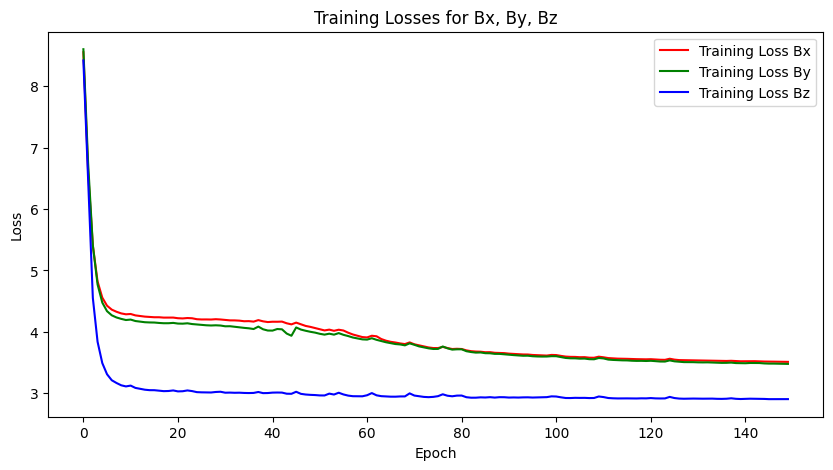

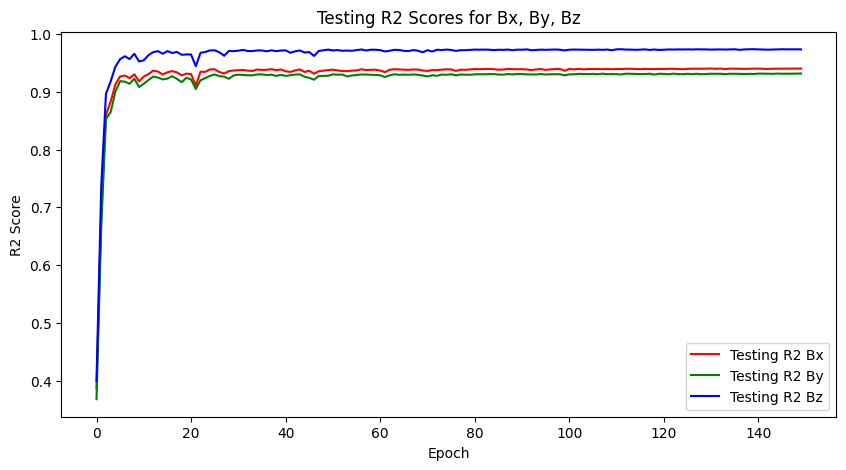

In [12]:
import os
import time
import csv
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

num_epochs = 150
print_frequency = 40
save_checkpoint_start_epoch = 20
save_checkpoint_interval = 10
checkpoint_dir = "result/NLFFF_Cube2Step/step2"
results_file = os.path.join(checkpoint_dir, "result.csv")

physics_loss_fn = PhysicsInformedLoss(weight=0.35, alpha=1, beta=1, gamma=1, delta = 0)
single_physics_loss_DIV_fn = singlePhysicsInformedDivergence_Loss(weight=1, alpha=1.0, beta=1, gamma=1)
single_physics_loss_FF_fn = singlePhysicsInformedForce_Free_Loss(weight=1, alpha=1.0, beta=1, gamma=1)

with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'comp', 'r2', 'relative_error', 'mse', 'mae', 'psnr', 'ssim'])

train_losses_Bx = []
train_losses_By = []
train_losses_Bz = []
test_losses_Bx = []
test_losses_By = []
test_losses_Bz = []
physics_losses_epoch = []
epoch_durations = []

#z_df = pd.read_csv(z_csv_path)
#z_values = z_df['z'].values
#assert len(z_values) == 25

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    epoch_loss_Bx = 0.0
    epoch_loss_By = 0.0
    epoch_loss_Bz = 0.0
    epoch_physics_loss = 0.0
    
    
    time_step_DIV_losses_accum = None
    time_step_FF_losses_accum = None

    train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Train Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (batch_i, sample) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        data, target = sample['input'].to(device0), sample['target'].to(device0)
        lengths = sample['lengths'].to(device0)  

        output = newmodel(data, lengths)

        #print(output.shape)

        loss_Bx = h1loss(output[:, :, 0, :, :], target[:, :, 0, :, :]).mean()
        loss_By = h1loss(output[:, :, 1, :, :], target[:, :, 1, :, :]).mean()
        loss_Bz = h1loss(output[:, :, 2, :, :], target[:, :, 2, :, :]).mean()

        physics_loss = physics_loss_fn(output, target)

        num_time_steps = output.size(1)

        if time_step_DIV_losses_accum is None:
            time_step_DIV_losses_accum = np.zeros(num_time_steps, dtype=np.float32)

        if time_step_FF_losses_accum is None:
            time_step_FF_losses_accum = np.zeros(num_time_steps, dtype=np.float32)

        for i in range(num_time_steps):
            DIV_losses_step = single_physics_loss_DIV_fn(output[:, i, :, :, :], target[:, i, :, :, :])
            DIV_losses_step_scalar = DIV_losses_step.mean().item()

            time_step_DIV_losses_accum[i] += DIV_losses_step_scalar

        for i in range(num_time_steps):
            FF_losses_step = single_physics_loss_FF_fn(output[:, i, :, :, :], target[:, i, :, :, :])
            FF_losses_step_scalar = FF_losses_step.mean().item()

            time_step_FF_losses_accum[i] += FF_losses_step_scalar        

        total_loss = loss_Bx + loss_By + loss_Bz + physics_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss_Bx += loss_Bx.item()
        epoch_loss_By += loss_By.item()
        epoch_loss_Bz += loss_Bz.item()
        epoch_physics_loss += physics_loss.item()

        if batch_idx % print_frequency == 0:
            train_loader_tqdm.set_postfix(
                loss_Bx=loss_Bx.item(),
                loss_By=loss_By.item(),
                loss_Bz=loss_Bz.item(),
                physics_loss=physics_loss.item()
            )

    avg_loss_Bx = epoch_loss_Bx / len(train_loader)
    avg_loss_By = epoch_loss_By / len(train_loader)
    avg_loss_Bz = epoch_loss_Bz / len(train_loader)
    avg_physics_loss = epoch_physics_loss / len(train_loader)

    train_losses_Bx.append(avg_loss_Bx)
    train_losses_By.append(avg_loss_By)
    train_losses_Bz.append(avg_loss_Bz)
    physics_losses_epoch.append(avg_physics_loss)

    all_E_pred = []
    all_E_true = []

    model.eval()
    epoch_r2_Bx = []
    epoch_r2_By = []
    epoch_r2_Bz = []
    test_loader_tqdm = tqdm(test_loader, total=len(test_loader), desc=f'Test Epoch {epoch+1}/{num_epochs}')
    with torch.no_grad():
        for sample in test_loader_tqdm:
            x = sample['input'].to(device0)
            lengths = sample['lengths'].to(device0)  
            target = sample['target'].cpu().numpy()
            output = newmodel(x, lengths).cpu().numpy()

            for true_sample, pred_sample in zip(target, output):
                r2_Bx = r2_score(true_sample[:, 0].flatten(), pred_sample[:, 0].flatten())
                r2_By = r2_score(true_sample[:, 1].flatten(), pred_sample[:, 1].flatten())
                r2_Bz = r2_score(true_sample[:, 2].flatten(), pred_sample[:, 2].flatten())

                epoch_r2_Bx.append(r2_Bx)
                epoch_r2_By.append(r2_By)
                epoch_r2_Bz.append(r2_Bz)


    avg_r2_Bx = np.mean(epoch_r2_Bx)
    avg_r2_By = np.mean(epoch_r2_By)
    avg_r2_Bz = np.mean(epoch_r2_Bz)

    test_losses_Bx.append(avg_r2_Bx)
    test_losses_By.append(avg_r2_By)
    test_losses_Bz.append(avg_r2_Bz)

    end_time = time.time()
    epoch_duration = end_time - start_time
    epoch_durations.append(epoch_duration)

    avg_train_loss_combined = (avg_loss_Bx + avg_loss_By + avg_loss_Bz + avg_physics_loss) / 3
    scheduler.step(avg_train_loss_combined)

    avg_epoch_duration = np.mean(epoch_durations)
    remaining_epochs = num_epochs - (epoch + 1)
    remaining_time = remaining_epochs * avg_epoch_duration
    hours, rem = divmod(remaining_time, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch: {epoch+1}/{num_epochs}, Duration: {epoch_duration:.2f}s, '
          f'Train Loss - Bx: {avg_loss_Bx:.4f}, By: {avg_loss_By:.4f}, Bz: {avg_loss_Bz:.4f}, Physics Loss: {avg_physics_loss:.4f}, '
          f'Test R2 - Bx: {avg_r2_Bx:.4f}, By: {avg_r2_By:.4f}, Bz: {avg_r2_Bz:.4f}')

    print(f'Estimated Remaining Time: {int(hours)}h {int(minutes)}m {int(seconds)}s')

    if (epoch + 1) >= save_checkpoint_start_epoch and (epoch + 1) % save_checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save(newmodel.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}: {checkpoint_path}")

        min_val = float('inf')
        max_val = float('-inf')

        for sample in test_loader:
            y_true_batch = sample['target'].numpy()
            batch_min = y_true_batch.min()
            batch_max = y_true_batch.max()
            min_val = min(min_val, batch_min)
            max_val = max(max_val, batch_max)

        data_range = max_val - min_val

        sample_r2_scores = {'bx': [], 'by': [], 'bz': []}
        sample_relative_errors = {'bx': [], 'by': [], 'bz': []}
        sample_mses = {'bx': [], 'by': [], 'bz': []}
        sample_maes = {'bx': [], 'by': [], 'bz': []}
        sample_psnr_values = {'bx': [], 'by': [], 'bz': []}
        sample_ssim_values = {'bx': [], 'by': [], 'bz': []}
        mean_std = {comp: {'mean': None, 'std': None} for comp in ['bx', 'by', 'bz']}
        true_values_by_component = {comp: [] for comp in ['bx', 'by', 'bz']}

        for sample in train_loader: 
            y_true_batch = sample['target'].cpu().numpy()
            for true_sample in y_true_batch:
                for i, comp in enumerate(['bx', 'by', 'bz']):
                    true_sample_component = true_sample[:, i]
                    true_sample_flat = true_sample_component.flatten()
                    true_values_by_component[comp].extend(true_sample_flat)

        for comp in ['bx', 'by', 'bz']:
            true_values = np.array(true_values_by_component[comp])
            mean_std[comp]['mean'] = np.mean(true_values)
            mean_std[comp]['std'] = np.std(true_values)

        for comp in mean_std:
            print(f"{comp} - Mean: {mean_std[comp]['mean']}, Std: {mean_std[comp]['std']}")

        model.eval()
        with torch.no_grad():
            for sample in test_loader:
                x = sample['input'].to(device0)
                lengths = sample['lengths'].to(device0)  
                y_true_batch = sample['target'].cpu().numpy()
                y_pred_batch = newmodel(x, lengths).cpu().numpy()

                for true_sample, pred_sample in zip(y_true_batch, y_pred_batch):
                    for i, comp in enumerate(['bx', 'by', 'bz']):
                        true_sample_component = true_sample[:, i]
                        pred_sample_component = pred_sample[:, i]

                        true_sample_flat = true_sample_component.flatten()
                        pred_sample_flat = pred_sample_component.flatten()

                        r2 = r2_score(true_sample_flat, pred_sample_flat)
                        sample_r2_scores[comp].append(r2)

                        mean = mean_std[comp]['mean']
                        std = mean_std[comp]['std']
                        true_sample_original = true_sample_flat * std + mean
                        pred_sample_original = pred_sample_flat * std + mean

                        absolute_error = np.linalg.norm(true_sample_original - pred_sample_original, 1)

                        relative_error = absolute_error / np.linalg.norm(true_sample_original, 1)
                        sample_relative_errors[comp].append(relative_error)

                        mse = mean_squared_error(true_sample_flat, pred_sample_flat)
                        sample_mses[comp].append(mse)

                        mae = mean_absolute_error(true_sample_flat, pred_sample_flat)
                        sample_maes[comp].append(mae)

                        psnr_value = psnr(true_sample_component, pred_sample_component, data_range=data_range)
                        sample_psnr_values[comp].append(psnr_value)

                        ssim_value = ssim(true_sample_component, pred_sample_component, data_range=data_range)
                        sample_ssim_values[comp].append(ssim_value)

        with open(results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            for comp in ['bx', 'by', 'bz']:
                writer.writerow([epoch+1, comp,
                                 np.mean(sample_r2_scores[comp]),
                                 np.mean(sample_relative_errors[comp]),
                                 np.mean(sample_mses[comp]),
                                 np.mean(sample_maes[comp]),
                                 np.mean(sample_psnr_values[comp]),
                                 np.mean(sample_ssim_values[comp])])

np.save(os.path.join(checkpoint_dir, 'train_losses_Bx.npy'), np.array(train_losses_Bx))
np.save(os.path.join(checkpoint_dir, 'train_losses_By.npy'), np.array(train_losses_By))
np.save(os.path.join(checkpoint_dir, 'train_losses_Bz.npy'), np.array(train_losses_Bz))
np.save(os.path.join(checkpoint_dir, 'test_losses_Bx.npy'), np.array(test_losses_Bx))
np.save(os.path.join(checkpoint_dir, 'test_losses_By.npy'), np.array(test_losses_By))
np.save(os.path.join(checkpoint_dir, 'test_losses_Bz.npy'), np.array(test_losses_Bz))

plt.figure(figsize=(10, 5))
plt.plot(train_losses_Bx, label='Training Loss Bx', color='red')
plt.plot(train_losses_By, label='Training Loss By', color='green')
plt.plot(train_losses_Bz, label='Training Loss Bz', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses for Bx, By, Bz')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_losses_Bx, label='Testing R2 Bx', color='red')
plt.plot(test_losses_By, label='Testing R2 By', color='green')
plt.plot(test_losses_Bz, label='Testing R2 Bz', color='blue')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Testing R2 Scores for Bx, By, Bz')
plt.legend()
plt.show()


In [12]:
newmodel.load_state_dict(torch.load("result/NLFFF_Cube2Step/step2/checkpoint_epoch_140.pt"))
newmodel.eval() 

/tmp/ipykernel_2217498/1754979559.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  newmodel.load_state_dict(torch.load("result/NLFFF_Cube2Step/step2/checkpoint_epoch_140.

CustomFNOnew(
  (DilatedConvYWithECA): DilatedConvYWithECA(
    (conv): Conv3d(25, 25, kernel_size=(1, 3, 1), stride=(1, 1, 1), padding=(0, 2, 0), dilation=(1, 2, 1), bias=False)
    (activation): ReLU()
    (eca): ECA3DLayer(
      (avg_pool): AdaptiveAvgPool3d(output_size=1)
      (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (lifting1): MLP(
    (fcs): ModuleList(
      (0): Conv3d(3, 25, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (lifting_y): MLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 25, kernel_size=(1,), stride=(1,))
    )
  )
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-5): 6 x ComplexTuckerTensor(shape=(25, 25, 32, 32, 17), rank=(18, 18, 23, 23, 12))
      )
    )
    (fno_skips): ModuleList(
      (0-5): 6 x Conv3d(25, 25, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# ============== 0) 工具函数：Figure → RGB ndarray ==============
def fig_to_rgb_array(fig):
    """
    把 Matplotlib Figure 转成 (H, W, 3) 的 uint8 RGB 数组
    兼容所有后端：先 draw() 再用 buffer_rgba()
    """
    fig.canvas.draw()                               # 必须先绘制
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img = buf.reshape(h, w, 4)[..., :3]             # 去掉 Alpha 通道
    return img

# ============== 1) 读取 CSV，获取和时间步对齐的 z 值 ==============
z_csv_path = "NLFFF_data/height_12443.csv"          # 替换为你的 CSV 路径
z_df = pd.read_csv(z_csv_path)
z_values = z_df["z"].values                         # shape: (time_length,)

# ============== 2) 遍历测试集并生成视频 ============================
output_dir = "result/NLFFF_Cube2Step/step2Test/visualizations"
os.makedirs(output_dir, exist_ok=True)

fps         = 3
frame_size  = (1024, 512)                           # (W, H) for VideoWriter
channel_ids = ["Bx", "By", "Bz"]

device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for sample_idx, sample in enumerate(test_dataset):

    # 2.1 取出单个样本
    input_data = sample["input"]                    # (T, 3, H, W)
    true_data  = sample["target"]                   # (T, 3, H, W)
    lengths    = sample["lengths"]

    # 2.2 推理
    with torch.no_grad():
        pred_batch = newmodel(
            input_data.unsqueeze(0).to(device0),    # (1, T, 3, H, W)
            lengths.to(device0)
        )
    pred_data = pred_batch.cpu().numpy()[0]         # (T, 3, H, W)

    time_length = pred_data.shape[0]

    # 2.3 为每个通道分别写 GT / Pred 视频
    for ch_idx, ch_name in enumerate(channel_ids):

        # ---------- 打开 VideoWriter ----------
        gt_path   = os.path.join(output_dir, f"gt_{ch_name}_sample_{sample_idx}.mp4")
        pred_path = os.path.join(output_dir, f"pred_{ch_name}_sample_{sample_idx}.mp4")

        gt_writer   = cv2.VideoWriter(gt_path,   cv2.VideoWriter_fourcc(*"mp4v"), fps, frame_size)
        pred_writer = cv2.VideoWriter(pred_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, frame_size)

        # ---------- 逐时间步写帧 ----------
        for t in range(time_length):

            z_val = z_values[t]

            true_frame = true_data[t, ch_idx]       # (H, W)
            pred_frame = pred_data[t, ch_idx]       # (H, W)

            vmin, vmax = true_frame.min(), true_frame.max()
            vmin = min(vmin, pred_frame.min())
            vmax = max(vmax, pred_frame.max())

            # ===== Ground Truth =====
            fig_gt, ax_gt = plt.subplots(figsize=(14, 7))
            plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
            ax_gt.imshow(true_frame, cmap="RdBu", origin="lower", vmin=vmin, vmax=vmax)
            ax_gt.axis("off")
            fig_gt.suptitle(f"{z_val} Mm", fontsize=14)

            gt_img = fig_to_rgb_array(fig_gt)
            gt_img = cv2.resize(gt_img, frame_size)
            gt_writer.write(cv2.cvtColor(gt_img, cv2.COLOR_RGB2BGR))
            plt.close(fig_gt)

            # ===== Prediction =====
            fig_pred, ax_pred = plt.subplots(figsize=(14, 7))
            plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
            ax_pred.imshow(pred_frame, cmap="RdBu", origin="lower", vmin=vmin, vmax=vmax)
            ax_pred.axis("off")

            pred_img = fig_to_rgb_array(fig_pred)
            pred_img = cv2.resize(pred_img, frame_size)
            pred_writer.write(cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR))
            plt.close(fig_pred)

        # ---------- 收尾 ----------
        gt_writer.release()
        pred_writer.release()
        print(f"[✓] sample {sample_idx} | {ch_name}: GT & Pred videos saved.")

print("✅ All videos have been generated.")


ERROR! Session/line number was not unique in database. History logging moved to new session 498
[✓] sample 0 | Bx: GT & Pred videos saved.
[✓] sample 0 | By: GT & Pred videos saved.
[✓] sample 0 | Bz: GT & Pred videos saved.
[✓] sample 1 | Bx: GT & Pred videos saved.
[✓] sample 1 | By: GT & Pred videos saved.
[✓] sample 1 | Bz: GT & Pred videos saved.
[✓] sample 2 | Bx: GT & Pred videos saved.
[✓] sample 2 | By: GT & Pred videos saved.
[✓] sample 2 | Bz: GT & Pred videos saved.
[✓] sample 3 | Bx: GT & Pred videos saved.
[✓] sample 3 | By: GT & Pred videos saved.
[✓] sample 3 | Bz: GT & Pred videos saved.
[✓] sample 4 | Bx: GT & Pred videos saved.
[✓] sample 4 | By: GT & Pred videos saved.
[✓] sample 4 | Bz: GT & Pred videos saved.
[✓] sample 5 | Bx: GT & Pred videos saved.
[✓] sample 5 | By: GT & Pred videos saved.
[✓] sample 5 | Bz: GT & Pred videos saved.
[✓] sample 6 | Bx: GT & Pred videos saved.
[✓] sample 6 | By: GT & Pred videos saved.
[✓] sample 6 | Bz: GT & Pred videos saved.
[

In [11]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim

output_dir = "result/NLFFF_Cube2Step/step2Test/cube"
os.makedirs(output_dir, exist_ok=True)

npy_dir = os.path.join(output_dir, "npy_data")
os.makedirs(npy_dir, exist_ok=True)

csv_path = os.path.join(output_dir, "cube_metrics.csv")

def mean_relative_error(y_true, y_pred, zeroarr):

    return mean_absolute_error(y_true, y_pred) / mean_absolute_error(y_true,zeroarr)

def compute_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return float("inf")
    data_range = np.max(y_true) - np.min(y_true)
    data_range = data_range if data_range > 0 else 1.0
    return 20 * np.log10(data_range / np.sqrt(mse))

def compute_ssim_cube(true_cube, pred_cube):
    ssim_vals = []
    for i in range(true_cube.shape[0]):
        data_range = true_cube[i].max() - true_cube[i].min()
        data_range = data_range if data_range > 0 else 1.0
        ssim_vals.append(
            ssim(true_cube[i], pred_cube[i], data_range=data_range)
        )
    return float(np.mean(ssim_vals))

# ---------------------- 主循环 ----------------------
rows = []

for sample_idx, sample in enumerate(test_dataset):

    input_data = sample["input"]          # (T, 3, H, W)  torch.Tensor
    true_data  = sample["target"]         # (T, 3, H, W)  torch.Tensor
    lengths    = sample["lengths"]        # (1,)          torch.Tensor

    print(true_data.shape)

    # 2) 推理
    with torch.no_grad():
        pred_batch = newmodel(
            input_data.unsqueeze(0).to(device0),  # (1, T, 3, H, W)
            lengths.to(device0)
        )
    pred_data = pred_batch.cpu().numpy()[0]       # (T, 3, H, W)
    true_data_np = true_data.cpu().numpy()        # (T, 3, H, W)

    # 3) 按通道处理
    for channel_idx, channel_name in enumerate(["Bx", "By", "Bz"]):
        pred_cube  = pred_data[:, channel_idx, :, :]    # (T, H, W)
        true_cube  = true_data_np[:, channel_idx, :, :]

        # --- 保存 npy ---
        np.save(
            os.path.join(npy_dir, f"sample_{sample_idx}_{channel_name}_pred.npy"),
            pred_cube
        )

        # --- 计算指标 ---
        y_true = true_cube.flatten()
        y_pred = pred_cube.flatten()
        

        r2_val   = r2_score(y_true, y_pred)
        mse_val  = mean_squared_error(y_true, y_pred)
        mae_val  = mean_absolute_error(y_true, y_pred)
        zeroarr = np.zeros(y_true.shape)
        re_val   = mean_relative_error(y_true, y_pred, zeroarr)
        psnr_val = compute_psnr(true_cube, pred_cube)
        ssim_val = compute_ssim_cube(true_cube, pred_cube)

        rows.append({
            "sample":  sample_idx,
            "channel": channel_name,
            "R2":      r2_val,
            "MSE":     mse_val,
            "MAE":     mae_val,
            "RE":      re_val,
            "PSNR":    psnr_val,
            "SSIM":    ssim_val
        })

        print(f"[Sample {sample_idx} - {channel_name}] "
              f"R2={r2_val:.4f}, MSE={mse_val:.3e}, MAE={mae_val:.3e}, "
              f"RE={re_val:.4f}, PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")

# 4) 保存 CSV
metrics_df = pd.DataFrame(rows)
metrics_df.to_csv(csv_path, index=False)
print(f"\n✓ 所有指标已保存到 {csv_path}")


torch.Size([25, 3, 257, 513])
[Sample 0 - Bx] R2=0.9441, MSE=5.595e-02, MAE=1.597e-01, RE=0.2359, PSNR=39.52, SSIM=0.8284
[Sample 0 - By] R2=0.9447, MSE=5.530e-02, MAE=1.665e-01, RE=0.2583, PSNR=39.35, SSIM=0.8231
[Sample 0 - Bz] R2=0.9792, MSE=2.081e-02, MAE=1.029e-01, RE=0.1892, PSNR=45.23, SSIM=0.9024
torch.Size([25, 3, 257, 513])
[Sample 1 - Bx] R2=0.9539, MSE=4.613e-02, MAE=1.383e-01, RE=0.1828, PSNR=37.98, SSIM=0.8977
[Sample 1 - By] R2=0.9397, MSE=6.026e-02, MAE=1.583e-01, RE=0.2508, PSNR=35.09, SSIM=0.8115
[Sample 1 - Bz] R2=0.9832, MSE=1.678e-02, MAE=8.591e-02, RE=0.1582, PSNR=43.77, SSIM=0.9136
torch.Size([25, 3, 257, 513])
[Sample 2 - Bx] R2=0.9695, MSE=3.051e-02, MAE=1.107e-01, RE=0.1824, PSNR=40.05, SSIM=0.8945
[Sample 2 - By] R2=0.9519, MSE=4.808e-02, MAE=1.407e-01, RE=0.2692, PSNR=39.35, SSIM=0.8011
[Sample 2 - Bz] R2=0.9859, MSE=1.414e-02, MAE=8.101e-02, RE=0.1838, PSNR=45.96, SSIM=0.9021
torch.Size([25, 3, 257, 513])
[Sample 3 - Bx] R2=0.8668, MSE=1.332e-01, MAE=2.523e